In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import functions
from scipy.interpolate import interp1d
import scipy.io
import statsmodels.api as sm
from scipy import integrate
from scipy.stats import norm 

## 1- Load and process mooring data

In [4]:
# mm = xr.open_dataset('LCC23_LCC3_Final1.nc') 
mm = xr.open_dataset('LCC23_LCC4_Final1.nc') 

In [5]:
depth = np.asarray(mm.depth)
u_est = np.asarray(mm.u)
v_north = np.asarray(mm.v)


df = pd.DataFrame(np.array(mm['time'].T.values), columns=["year", "month", "day", "hour", "minute", "second"])

df[['year', 'month', 'day', 'hour', 'minute', 'second']] = df[['year', 'month', 'day', 'hour', 'minute', 'second']].astype(int)

time = pd.to_datetime(df)

print('First measure:', mm.time_end.values)
print('Last measure:',mm.time_end.values)

First measure: [[2024.]
 [   9.]
 [  25.]
 [  16.]
 [  40.]
 [   9.]]
Last measure: [[2024.]
 [   9.]
 [  25.]
 [  16.]
 [  40.]
 [   9.]]


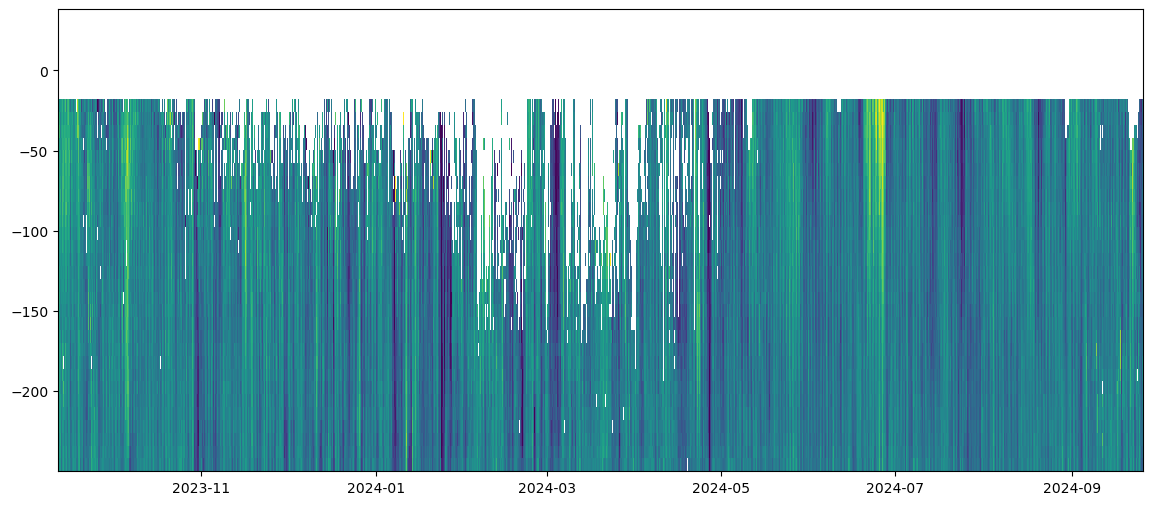

In [6]:
depth_clean = np.nanmean(mm.depth, axis=0)

plt.figure(figsize=(14, 6))
plt.pcolormesh(time, -depth_clean ,v_north.T, cmap='viridis', shading='auto', vmin=-0.45, vmax=0.45)
# plt.savefig('LCC3_u_test.png', dpi=300);

In [7]:
bins = np.arange(1, mm.bins + 1)  # 1 to 33
Ntime, NCell = mm.u.shape
Zbin = - mm.nominal_depth.values + mm.bin1_dist.values + mm.bin_size.values * (np.arange(1, NCell + 1)-0.5)

Zbin

array([[-246.11, -238.11, -230.11, -222.11, -214.11, -206.11, -198.11,
        -190.11, -182.11, -174.11, -166.11, -158.11, -150.11, -142.11,
        -134.11, -126.11, -118.11, -110.11, -102.11,  -94.11,  -86.11,
         -78.11,  -70.11,  -62.11,  -54.11,  -46.11,  -38.11,  -30.11,
         -22.11,  -14.11,   -6.11,    1.89,    9.89,   17.89,   25.89,
          33.89]])

In [8]:
ds = xr.Dataset(
data_vars={
        'velocity_east': (["TIME","DEPTH"], mm.u.values), 
        'velocity_north': (["TIME","DEPTH"], mm.v.values), 
    },
        coords = dict(
            DEPTH = Zbin[0,:],
            TIME = time
                )
                )

In [9]:
monthly_idx = ds.groupby('TIME.month').groups
jan_idx = monthly_idx[1]
ds_jan = ds.isel(TIME=jan_idx)

feb_idx = monthly_idx[2]
ds_feb = ds.isel(TIME=feb_idx)

march_idx = monthly_idx[3]
march_jan = ds.isel(TIME=march_idx)

apr_idx = monthly_idx[4]
apr_jan = ds.isel(TIME=apr_idx)

may_idx = monthly_idx[5]
ds_may = ds.isel(TIME=may_idx)

jun_idx = monthly_idx[6]
ds_jun = ds.isel(TIME=jun_idx)

jul_idx = monthly_idx[7]
ds_jul = ds.isel(TIME=jul_idx)

aug_idx = monthly_idx[8]
ds_aug = ds.isel(TIME=aug_idx)

sep_idx = monthly_idx[9]
ds_sep = ds.isel(TIME=sep_idx)

oct_idx = monthly_idx[10]
ds_oct = ds.isel(TIME=oct_idx)

nov_idx = monthly_idx[11]
ds_nov = ds.isel(TIME=nov_idx)

dec_idx = monthly_idx[12]
ds_dec = ds.isel(TIME=dec_idx)


# winter_idx = np.concatenate([jan_idx, feb_idx, march_idx])
# ds = ds.isel(TIME=winter_idx)

# spring_idx = np.concatenate([apr_idx, may_idx, jun_idx])
# ds = ds.isel(TIME=spring_idx)

# summer_idx = np.concatenate([jul_idx, aug_idx, sep_idx])
# ds_summer = ds.isel(TIME = summer_idx)
# ds = ds_summer.sel( TIME = ds_summer.TIME.dt.year == 2024)

# aut_idx = np.concatenate([oct_idx, nov_idx, dec_idx])
# ds = ds.isel(TIME=aut_idx)

In [10]:
day = np.datetime64("2023-10-30")
# ds = ds.where((ds.DEPTH <= -23.07), drop=True)    ## remove upper data for LCC3
ds = ds.where((ds.DEPTH <= -22.11), drop=True)  ## for LCC4
# ds = ds.where((ds.TIME <= time), drop=True) 
# ds = ds.where((ds.DEPTH <= -60)) 

In [11]:
u = ds.velocity_east.values  
v = ds.velocity_north.values  
depths = ds.DEPTH.values          
times = ds.TIME.values   

Text(0.5, 0, 'Date')

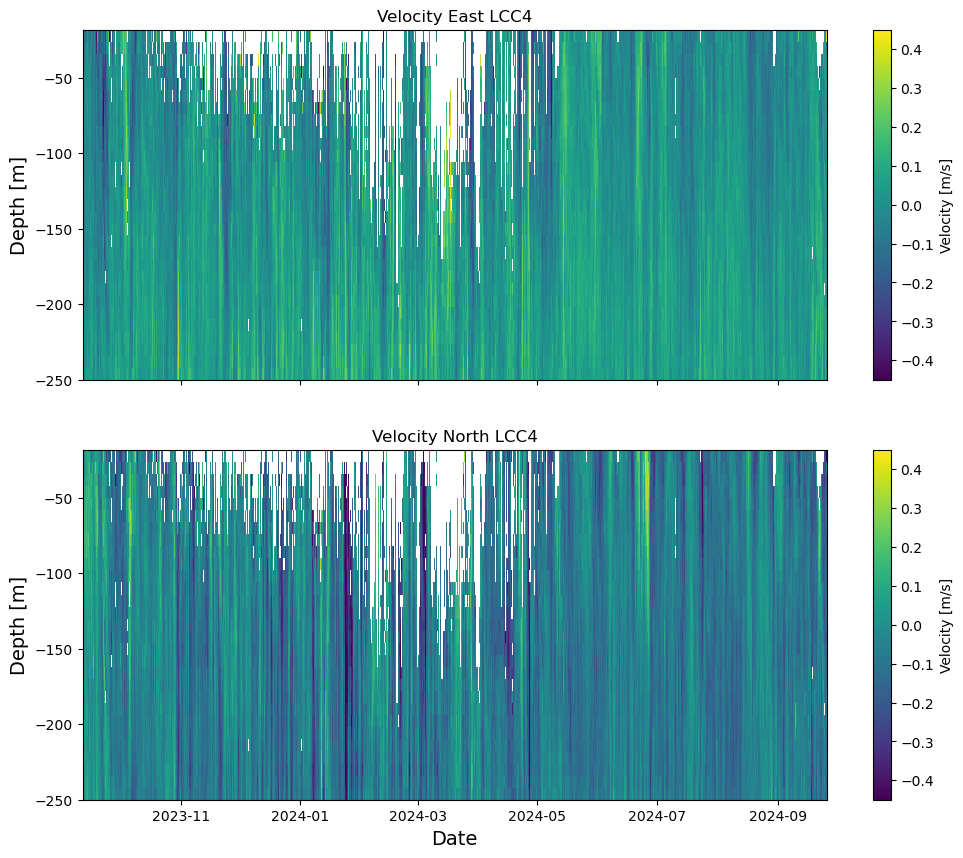

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column

pcm0 = axs[0].pcolormesh(ds.TIME, ds.DEPTH ,ds.velocity_east.T, cmap='viridis', vmin=-0.45, vmax=0.45)
axs[0].set_title('Velocity East LCC4')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


pcm1 = axs[1].pcolormesh(ds.TIME, ds.DEPTH, ds.velocity_north.T, cmap='viridis', vmin=-0.45,vmax=0.45)
axs[1].set_title('Velocity North LCC4')
axs[1].set_ylabel('Depth [m]', fontsize=14)
cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14)
# plt.savefig('LCC4_velocities.png', dpi=300);

### Function to fill the data gap by extrapolating

In [14]:
def vertical_fill(col):
    """
    Fill missing values in a column using linear interpolation between valid points and least-squares linear extrapolation beyond the valid data range.
    Parameters:
    - col: 1D along depth axis
    Returns:
    - 1D array with NaNs filled using interpolation and least-squares extrapolation
    """
    valid = ~ np.isnan(col)
    if valid.sum() < 2:
        return col # not enough values to interpolate

    valid_depths = depths[valid]
    valid_values = col[valid]
    full_col = col.copy()

    f_interp = interp1d(valid_depths, valid_values, bounds_error=False)
    interp_mask = (depths >= valid_depths.min()) & (depths <= valid_depths.max())
    full_col[interp_mask] = f_interp(depths[interp_mask])
    
    upper_mask = depths < valid_depths.min()
    if np.any(upper_mask):
        idx = np.argsort(valid_depths)[:5]  
        if len(idx) >= 2:
            slope, intercept = np.polyfit(valid_depths[idx], valid_values[idx], 1)
            full_col[upper_mask] = slope * depths[upper_mask] + intercept

    lower_mask = depths > valid_depths.max()
    if np.any(lower_mask):
        idx = np.argsort(valid_depths)[-5:]  # deepest n_fit points  
        if len(idx) >= 2:
            slope, intercept = np.polyfit(valid_depths[idx], valid_values[idx], 1)
            full_col[lower_mask] = slope*depths[lower_mask] + intercept

    
    return full_col

Text(0.5, 0, 'Date')

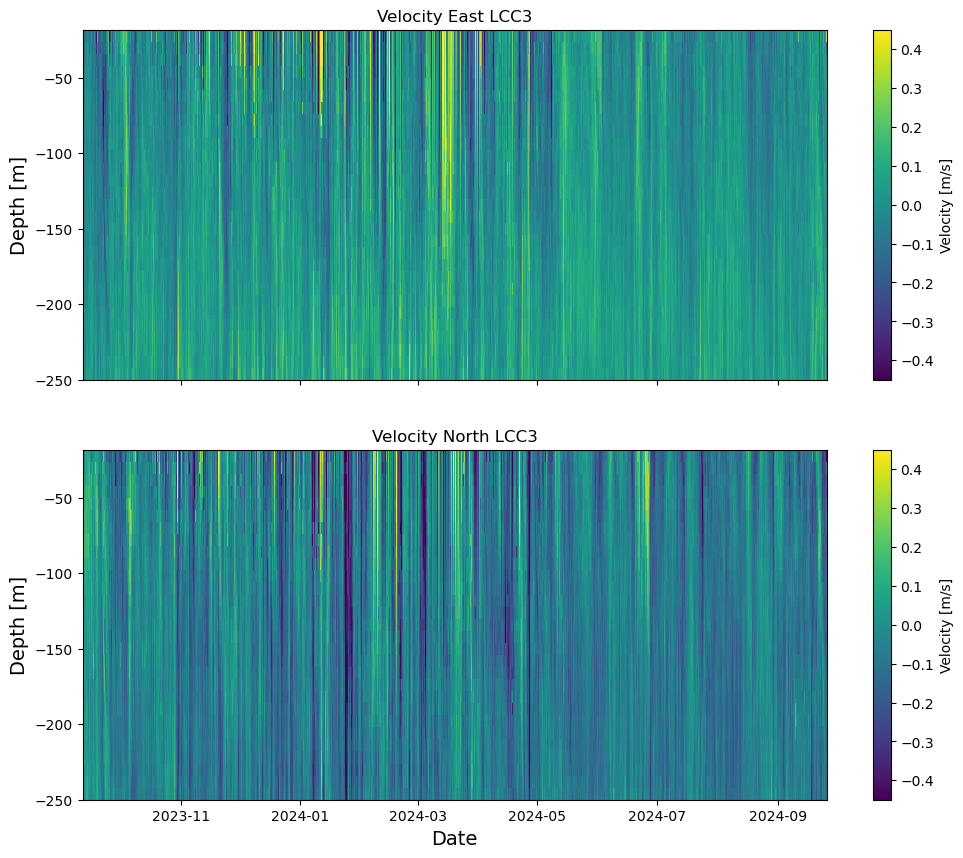

In [15]:
############################
#''''''''it extends the linear trend defined by the two closest oundary points (i.e., linear extrapolation from the nearest segment)'''''
# def vertical_fill(col):
#     valid = ~np.isnan(col)
#     if valid.sum() < 2:
#         return col  
#     f = interp1d(depths[valid], col[valid], bounds_error=False, fill_value="extrapolate")
#     return f(depths)

# def horizontal_fill(row, times):
#     valid = ~np.isnan(row)
#     if valid.sum() < 2:
#         return row  # Not enough points to interpolate
#     f = interp1d(times[valid], row[valid], bounds_error=False, fill_value="extrapolate")
#     return f(times)


#############################

u_interp = np.apply_along_axis(vertical_fill, axis=0, arr=u.T).T
v_interp = np.apply_along_axis(vertical_fill, axis=0, arr=v.T).T

fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column

pcm0 = axs[0].pcolormesh(ds.TIME, depths ,u_interp.T, cmap='viridis', vmin=-0.45, vmax=0.45)
axs[0].set_title('Velocity East LCC3')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


pcm1 = axs[1].pcolormesh(ds.TIME, depths, v_interp.T, cmap='viridis', vmin=-0.45,vmax=0.45)
axs[1].set_title('Velocity North LCC3')
axs[1].set_ylabel('Depth [m]', fontsize=14)
cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14)
# plt.savefig('LCC3_velocities_interp.png', dpi=300);

### Temporal filtering

In [17]:
dm_u = pd.DataFrame({'Time':ds.TIME, 'Value': np.nanmean(u_interp, axis=1)})
dm_u = dm_u.set_index('Time')
dm_u = dm_u.resample('1h').mean()
filtered_u = functions.filter_velocity(dm_u['Value'])

dm_v = pd.DataFrame({'Time':ds.TIME, 'Value': np.nanmean(v_interp, axis=1)})
dm_v = dm_v.set_index('Time')
dm_v = dm_v.resample('1h').mean()
filtered_v = functions.filter_velocity(dm_v['Value'])

### Method 1: Filter the original data

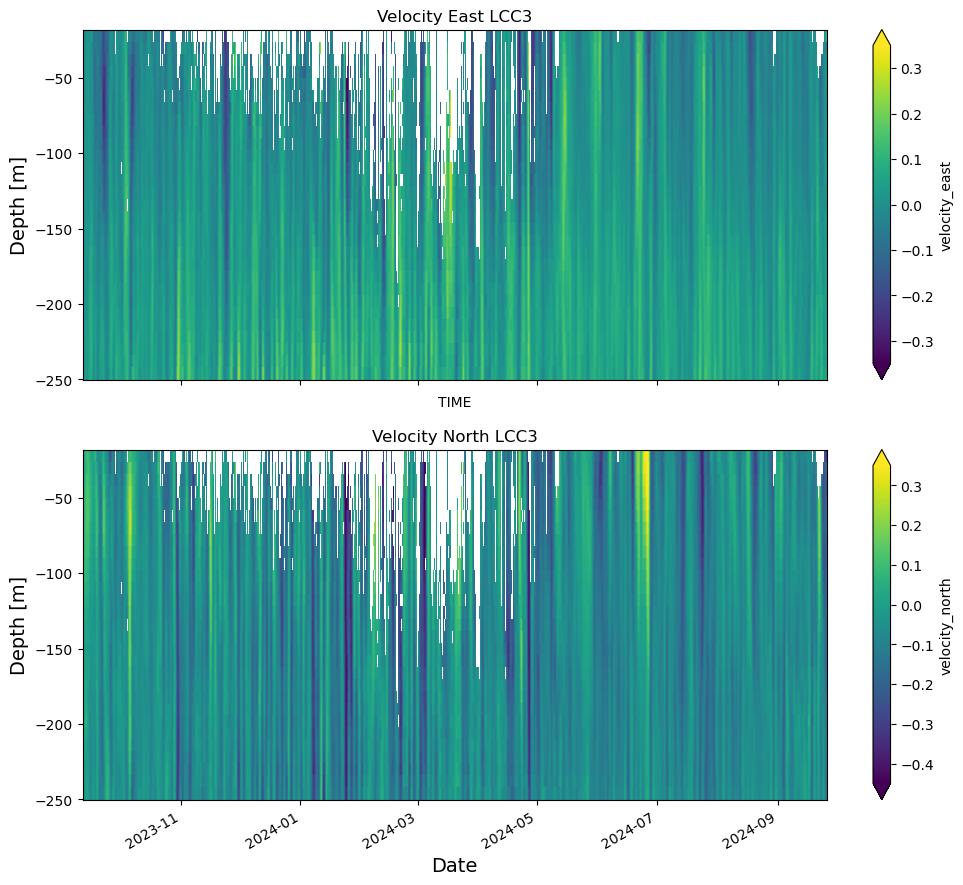

In [19]:
ds.velocity_east['TIME'] = pd.to_datetime(ds.velocity_east['TIME'].values)
ds.velocity_north['TIME'] = pd.to_datetime(ds.velocity_north['TIME'].values)

u_new = ds.velocity_east.copy()
v_new = ds.velocity_north.copy()

u_newD = u_new.resample(TIME='1h').mean(skipna=True)
v_newD = v_new.resample(TIME='1h').mean(skipna=True)

def filter_along_time(da):  # input da
    isnan = da.isnull()   # isnan = da.isnull()
    da_interp = da.interpolate_na(dim='TIME', method='linear', fill_value="extrapolate") # interpolates missing values along the TIME
    filtered =  xr.apply_ufunc(  
        functions.filter_velocity,    
        da_interp,
        input_core_dims=[['TIME']],
        output_core_dims=[['TIME']],
        vectorize=True,  # Applies the function to each array element
        dask='parallelized',  # Enables parallel processing with dask
        output_dtypes=[da.dtype] # Ensures the output has the same data type as the input
    )
    filtered = filtered.where(~isnan)
    return filtered
    
filtered_u2 =  u_newD.groupby('DEPTH').map(filter_along_time)   
filtered_v2 =  v_newD.groupby('DEPTH').map(filter_along_time)  


fig, axs = plt.subplots(2, 1, figsize=(12, 10))  

pcm0 = filtered_u2.plot.pcolormesh(ax=axs[0],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.35, vmax=0.35)
axs[0].set_title('Velocity East LCC3')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
# cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


pcm1 = filtered_v2.plot.pcolormesh(ax=axs[1],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.35)
axs[1].set_title('Velocity North LCC3')
axs[1].set_ylabel('Depth [m]', fontsize=14)
# cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14);
# plt.savefig('LCC3_velocities_filter_aut.png', dpi=300);

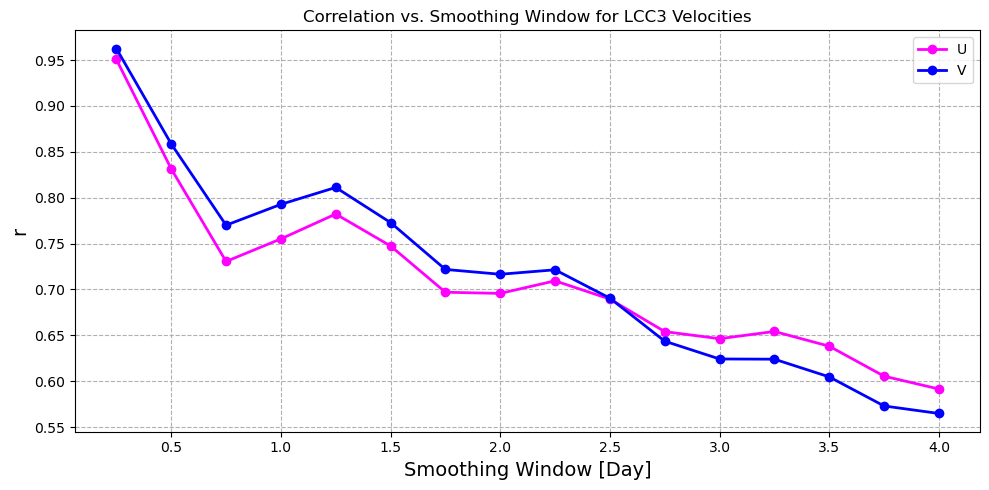

In [20]:
depth_index = 10 
u_bin = u_newD[:, depth_index].values
v_bin = v_newD[:, depth_index].values

df = pd.DataFrame({'u': u_bin, 'v': v_bin}, index=u_newD.TIME.values)

windows = np.arange(6, 101, 6)
r_u = []
r_v = []

for w in windows:
    u_smooth = df['u'].rolling(window=w, center=True).mean()
    v_smooth = df['v'].rolling(window=w, center=True).mean()
    
    # Drop NaNs caused by rolling
    valid = ~np.isnan(u_smooth) & ~np.isnan(u_bin)
    corr_u = np.corrcoef(u_smooth[valid], u_bin[valid])[0, 1]
    corr_v = np.corrcoef(v_smooth[valid], v_bin[valid])[0, 1]
    r_u.append(corr_u)
    r_v.append(corr_v)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(windows/24, r_u, marker='o', c='magenta', linewidth=2, label='U')
plt.plot(windows/24, r_v, marker='o', c='blue', linewidth=2,label='V')
plt.xlabel('Smoothing Window [Day]', fontsize=14)
plt.ylabel('r', fontsize=14)
plt.title('Correlation vs. Smoothing Window for LCC3 Velocities')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
# plt.savefig('LCC3_smoothing.png', dpi=300);

Text(0.5, 0, 'Date')

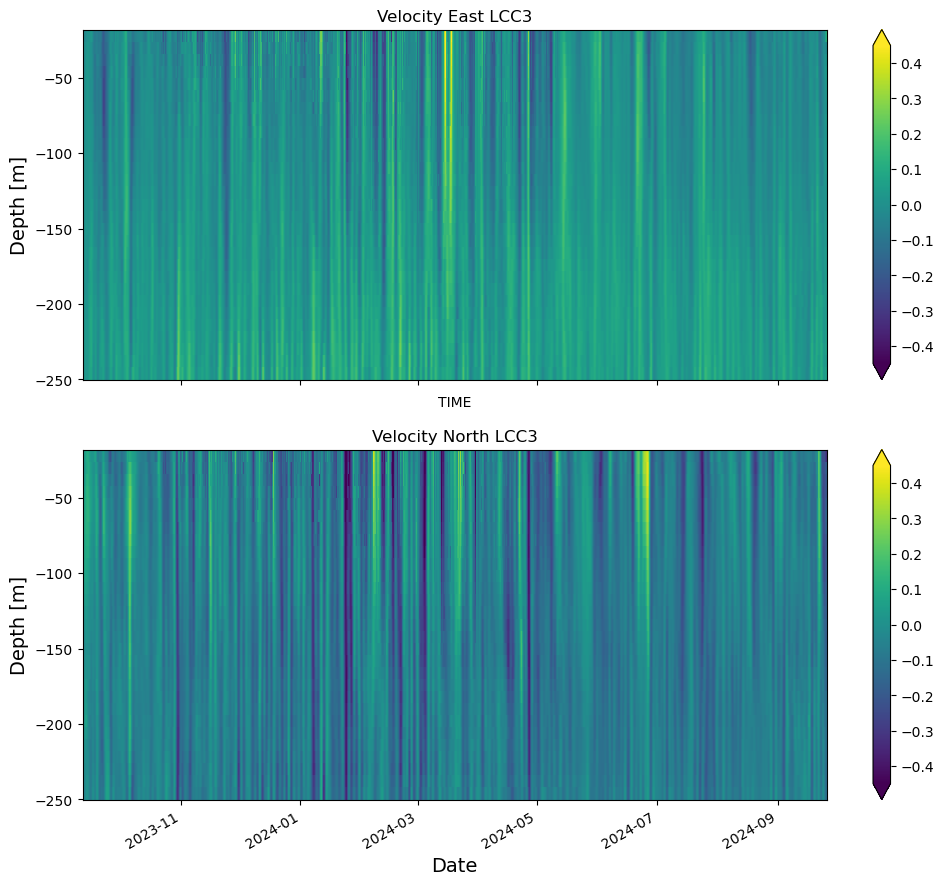

In [21]:
u_interp2 = np.apply_along_axis(vertical_fill, axis=0, arr=filtered_u2.T).T
v_interp2 = np.apply_along_axis(vertical_fill, axis=0, arr=filtered_v2.T).T

new_time_coords = filtered_u2['TIME'].values
new_depth_coords = filtered_u2['DEPTH'].values

u_da2 = xr.DataArray(u_interp2, coords={'TIME': new_time_coords, 'DEPTH': new_depth_coords}, dims=['TIME', 'DEPTH'])
v_da2 = xr.DataArray(v_interp2, coords={'TIME': new_time_coords, 'DEPTH': new_depth_coords}, dims=['TIME', 'DEPTH'])

fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column

pcm0 = u_da2.plot.pcolormesh(ax=axs[0],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[0].set_title('Velocity East LCC3')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
# cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


pcm1 = v_da2.plot.pcolormesh(ax=axs[1],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[1].set_title('Velocity North LCC3')
axs[1].set_ylabel('Depth [m]', fontsize=14)
# cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14)
# plt.savefig('LCC3_velocities_filter+interp.png', dpi=300);

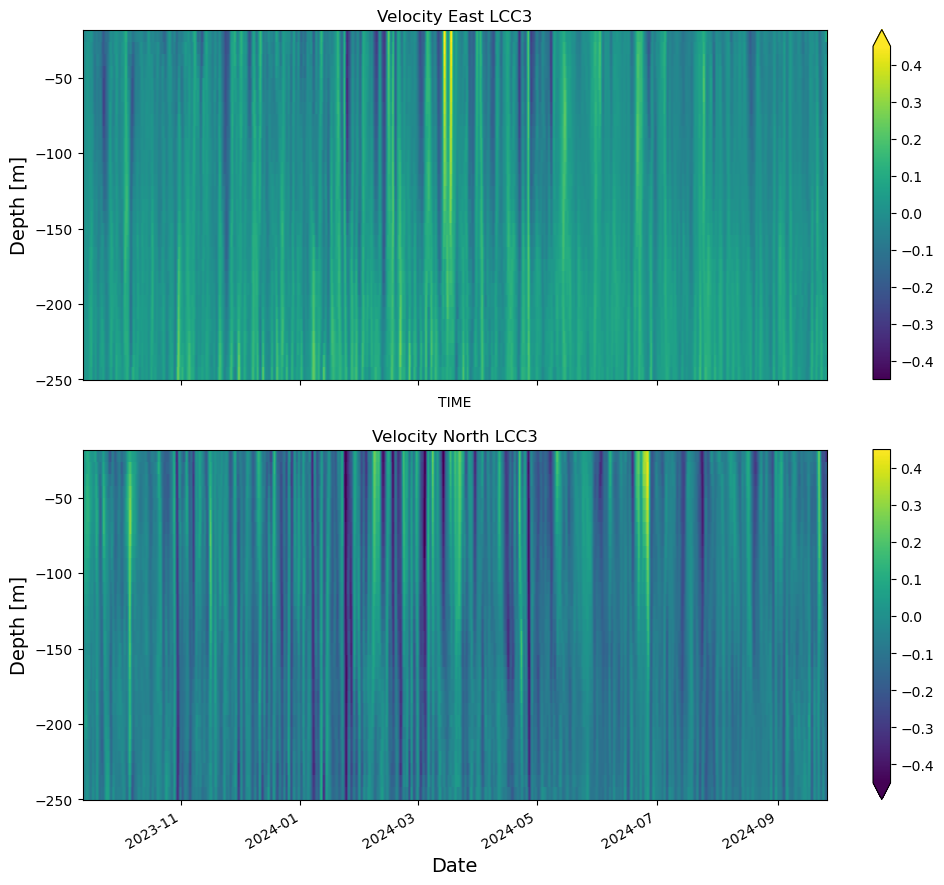

In [22]:
time_coords = pd.to_datetime(times)  
depth_coords = depths             

u_da = xr.DataArray(u_interp, coords={'TIME': time_coords, 'DEPTH': depth_coords}, dims=['TIME', 'DEPTH'])
v_da = xr.DataArray(v_interp, coords={'TIME': time_coords, 'DEPTH': depth_coords}, dims=['TIME', 'DEPTH'])

u_newD = u_da.resample(TIME='1h').mean(skipna=True)
v_newD = v_da.resample(TIME='1h').mean(skipna=True)

def filter_along_time(da):
    # isnan = da.isnull()
    # da_interp = da.interpolate_na(dim='TIME', method='linear', fill_value="extrapolate")
    filtered =  xr.apply_ufunc(
        functions.filter_velocity,
        da,
        input_core_dims=[['TIME']],
        output_core_dims=[['TIME']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[da.dtype]
    )
    # filtered = filtered.where(~isnan)
    return filtered
    
filtered_u_f =  u_newD.groupby('DEPTH').map(filter_along_time)   
filtered_v_f =  v_newD.groupby('DEPTH').map(filter_along_time)   


fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column

pcm0 = filtered_u_f.plot.pcolormesh(ax=axs[0],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[0].set_title('Velocity East LCC3')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


pcm1 = filtered_v_f.plot.pcolormesh(ax=axs[1],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[1].set_title('Velocity North LCC3')
axs[1].set_ylabel('Depth [m]', fontsize=14)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14);
# plt.savefig('LCC3_velocities_interp+filter.png', dpi=300);

In [23]:
# filtered_u2.where(filtered_u2.DEPTH >= -40, drop=True).values

# limit_day = pd.to_datetime('2023-09-17')

# filtered_u2.where(
#     (filtered_u2.TIME.dt.date == limit_day.date()) & 
#     (filtered_u2.DEPTH >= -40),
#     drop=True
# ).values

In [24]:
# v_da2.sel(TIME = "2024-02-25")

# filtered_v2.sel(TIME = "2024-02-25")

Text(0.5, 0, 'Date')

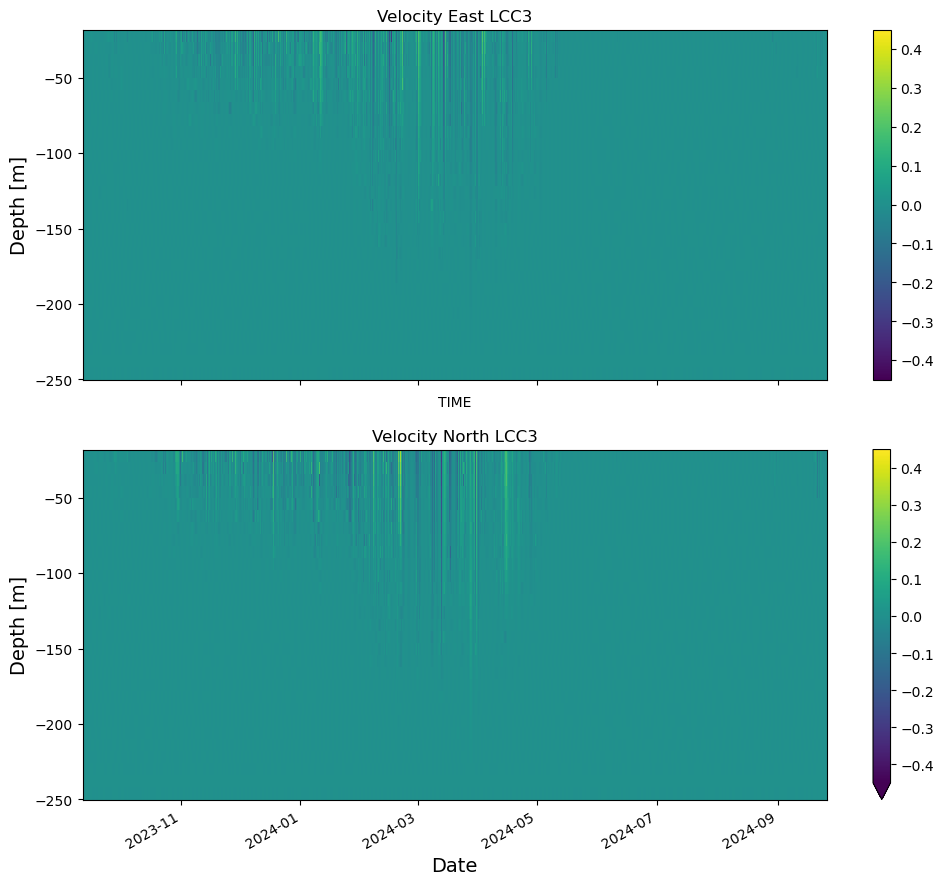

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))  # 4 rows, 1 column


pcm0 = (u_da2-filtered_u_f).plot.pcolormesh(ax=axs[0],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[0].set_title('Velocity East LCC3')
axs[0].set_ylabel('Depth [m]',fontsize=14)
axs[0].set_xticklabels([]) 
# cbar0 = plt.colorbar(pcm0, ax=axs[0], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[0].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])


# pcm1 = axs[1].pcolormesh(filtered_u2['TIME'].values, filtered_u2['DEPTH'].values, (v_da2-filtered_v2).T, cmap='viridis', vmin=-0.1,vmax=0.1)
pcm1 = (v_da2-filtered_v_f).plot.pcolormesh(ax=axs[1],x='TIME', y='DEPTH', cmap='viridis',vmin=-0.45, vmax=0.45)
axs[1].set_title('Velocity North LCC3')
axs[1].set_ylabel('Depth [m]', fontsize=14)
# cbar1 = plt.colorbar(pcm1, ax=axs[1], label='Velocity [m/s]', shrink=1, pad=0.05)
# axs[1].set_yticks([0, -25, -50, -75,-100,-125,-150,-175,-200], ['0', '25', '50', '75', '100', '125', '150','175','200'])
axs[1].set_xlabel('Date', fontsize=14)
# plt.savefig('LCC3_velocities_diff.png', dpi=300);

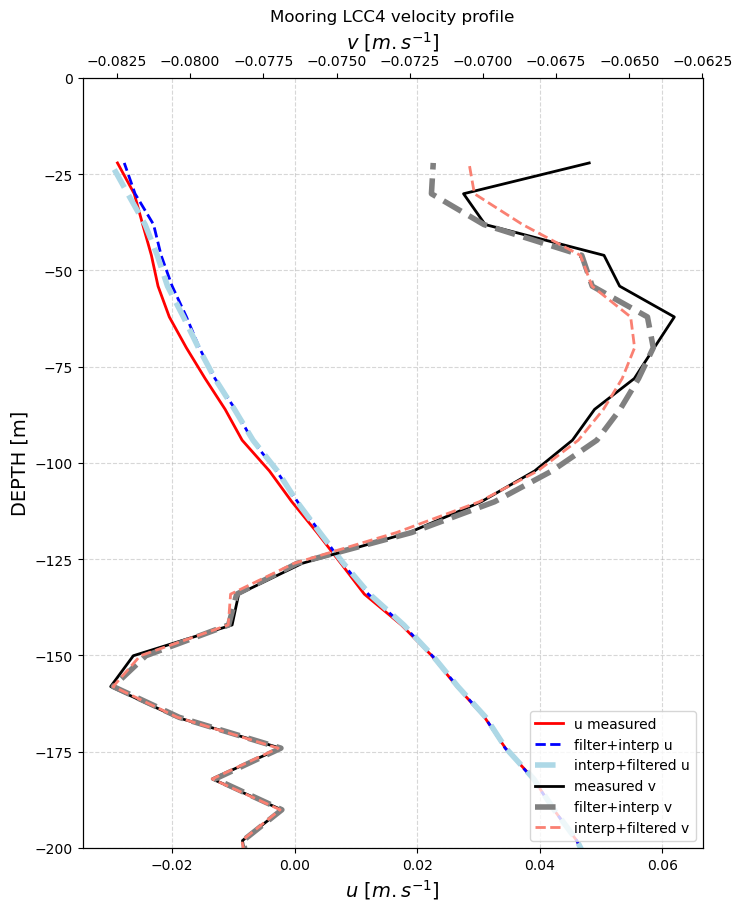

In [26]:
# plt.figure(figsize=(6, 6))
# # plt.plot(np.nanmean(ds.velocity_east, axis=0), ds.DEPTH, c='b')
# plt.plot(np.nanmean(u_da2, axis=0), ds.DEPTH, linestyle='--', c='r',label='filter+interp')
# plt.plot(np.nanmean(filtered_u2, axis=0), ds.DEPTH, c='b',label='filtered')
# plt.plot(np.nanmean(filtered_u_f, axis=0), ds.DEPTH, linestyle='--', c='k',label='interp+filtered')
# plt.xlabel(r'$u~[m.s^{-1}]$', fontsize=14)
# plt.ylabel('Depth [m]', fontsize=14)
# plt.title('Mooring LCC3 mean velocity profile', fontsize=14)
# plt.grid(True, alpha=0.2)
# plt.legend();

fig, ax1 = plt.subplots(figsize=(8, 10))

ax1.plot(np.nanmean(u, axis=0), depths, c='r',linewidth=2,label='u measured')
ax1.plot(np.nanmean(u_da2, axis=0), ds.DEPTH, linestyle='--', linewidth=2,c='b',label='filter+interp u')
ax1.plot(np.nanmean(filtered_u_f, axis=0), ds.DEPTH, linestyle='--',linewidth=4, c='lightblue',label='interp+filtered u')
ax1.set_xlabel(r'$u~[m.s^{-1}]$', fontsize=14)
ax1.set_ylabel('DEPTH [m]',fontsize=14)
ax1.grid(linestyle='--', alpha=0.5)

ax2 = ax1.twiny()
ax2.plot(np.nanmean(v, axis=0), depths, c='k',linewidth=2,label='measured v')
ax2.plot(np.nanmean(v_da2, axis=0), ds.DEPTH, linestyle='--', c='gray', linewidth=4, label='filter+interp v')
ax2.plot(np.nanmean(filtered_v_f, axis=0), ds.DEPTH, linestyle='--', linewidth=2, c='salmon',label='interp+filtered v')
ax2.set_ylim(-200, 0)
ax2.set_xlabel(r'$v~[m.s^{-1}]$', fontsize=14)


plt.title('')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.title('Mooring LCC4 velocity profile')
# plt.savefig('Figures/velociticy_full_profile.png', dpi=300)
plt.show()

In [27]:
# depth_mask = (depths >= -65) & (depths <= -40)
# u_layer = u_da2.sel(DEPTH=depth_mask)
# v_layer = v_da2.sel(DEPTH=depth_mask)

# output_df = pd.DataFrame({'time': u_da2.TIME, 
#                           'filtered_u': np.nanmean(u_layer, axis=1), 'filtered_v':np.nanmean(v_layer, axis=1)})

# # output_df = pd.DataFrame({'time': df_swot_u.index, 
# #                           'u_geos': df_interp_swot_u['u_total'], 'v_geos':df_interp_swot_v['v_total']})

# output_df.to_csv('ugos_LCC3_final.csv', index=False)

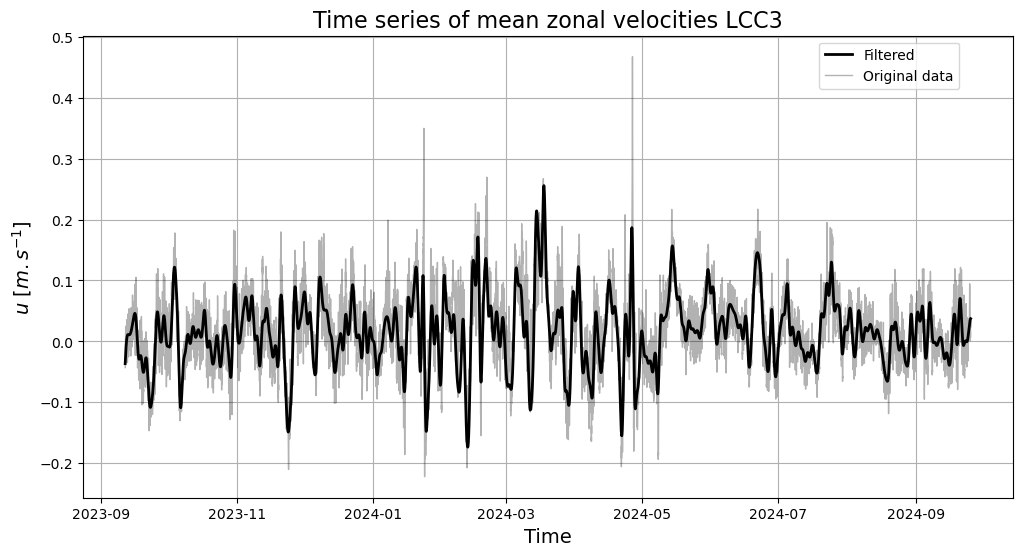

In [28]:
plt.figure(figsize=(12, 6))
# plt.plot(dm_u.index, filtered_u ,'k', label='Filtered', linewidth=2)
plt.plot(filtered_u2['TIME'], np.nanmean(filtered_u_f, axis=1) ,'k', label='Filtered', linewidth=2)
# plt.plot(dm_u ,'k', label='Filtered', linewidth=1, alpha=0.5)
plt.plot(ds.TIME, np.nanmean(ds.velocity_east, axis=1), 'k', label='Original data', linewidth=1, alpha=0.3)
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$u~[m.s^{-1}]$', fontsize=14)
plt.title('Time series of mean zonal velocities LCC3', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=(0.95, 1))
# plt.savefig('LCC3_u.png', dpi=300);

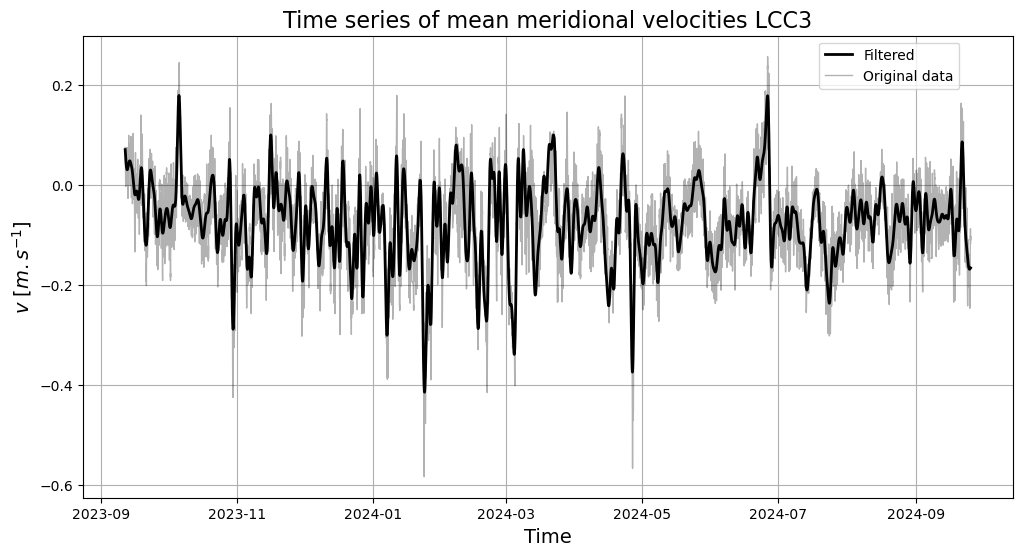

In [29]:
plt.figure(figsize=(12, 6))
# plt.plot(dm_v.index, filtered_v ,'k', label='Filtered')
plt.plot(filtered_v2['TIME'], np.nanmean(filtered_v_f, axis=1) ,'k', label='Filtered', linewidth=2)
# plt.plot(filtered_v2['TIME'], np.nanmean(u_da2, axis=1) ,'b', label='Filtered', linewidth=2)
plt.plot(ds.TIME, np.nanmean(ds.velocity_north, axis=1), 'k', label='Original data', linewidth=1, alpha=0.3)
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$v~[m.s^{-1}]$', fontsize=14)
plt.title('Time series of mean meridional velocities LCC3', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=(0.95, 1))
# plt.savefig('LCC3_v.png', dpi=300);

In [30]:
ek_layer = (depths >= -65) & (depths <= -40)

u_layer = u_da2[:, ek_layer]   
v_layer = v_da2[:, ek_layer]

# u_layer_original = ds.velocity_east[:, ek_layer]   
# v_layer_original = ds.velocity_north[:, ek_layer]

u_layer_mean = np.nanmean(u_layer, axis=1)
v_layer_mean = np.nanmean(v_layer, axis=1)

# u_layer_mean1 = np.nanmean(u_layer1, axis=1)
# v_layer_mean1 = np.nanmean(v_layer1, axis=1)

# u_layer_original_mean = np.mean(u_layer_original, axis=1)
# v_layer_original_mean = np.mean(u_layer_original, axis=1)

In [31]:
LCC4 = pd.read_csv('LCC4.csv')
LCC4['time'] = pd.to_datetime(LCC4['time'])

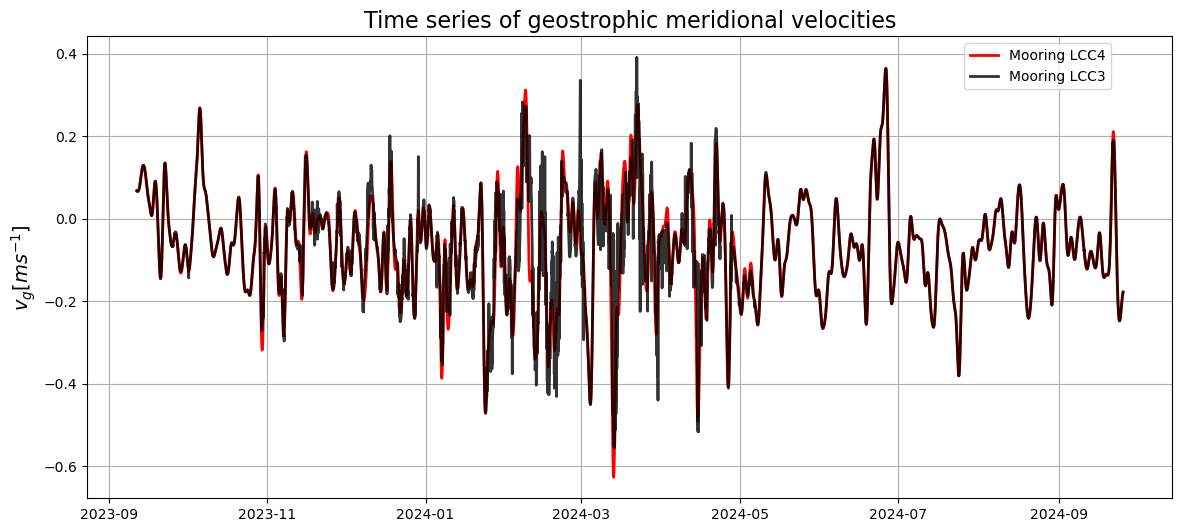

In [32]:
plt.figure(figsize=(14, 6))

plt.plot(LCC4['time'], LCC4.v_layer, label='Mooring LCC4', color='r', linewidth=2)

plt.plot(v_da2['TIME'], v_layer_mean, label='Mooring LCC3', color='k', linewidth=2, alpha=0.8)

# plt.yticks([-0.2, -0.1, 0, 0.1,0.2,0.3,0.4,0.5], ['- 0.2','- 0.1','0', '0.1', '0.2', '0.3', '0.4','0.5'])
# plt.tick_params(axis='x', labelsize=12, colors='k')
# plt.tick_params(axis='y', labelsize=12, colors='k')

# plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$v_{g} [m s^{-1}]$', fontsize=14)
plt.title('Time series of geostrophic meridional velocities', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=(0.95, 1))
# plt.savefig('LCC3vsLCC4_method2_v.png', dpi=300);

## Getting the SWOT satellite data

In [34]:
start = np.datetime64("2023-09-10")
end = np.datetime64("2024-09-30")
# end = np.datetime64("2023-10-30")
sp46 = xr.open_dataset('data_SWOT_aroundLCC4/SWOT_meanover46_LCC4.nc')
sp46 = sp46.where((sp46.time46 >= start) & (sp46.time46 <= end), drop=True)
sp201 = xr.open_dataset('data_SWOT_aroundLCC4/SWOT_meanover201_LCC4.nc')
sp201 = sp201.where((sp201.time201 >= start) & (sp201.time201 <= end), drop=True)
sp479 = xr.open_dataset('data_SWOT_aroundLCC4/SWOT_meanover479_LCC4.nc')
sp479 = sp479.where((sp479.time479 >= start) & (sp479.time479 <= end), drop=True)

In [35]:
# monthly_idx_swot = sp46.groupby('time46.month').groups
# monthly_idx_swot201 = sp201.groupby('time201.month').groups
# monthly_idx_swot479 = sp479.groupby('time479.month').groups

# # winter_idx = np.concatenate([monthly_idx_swot[1], monthly_idx_swot[2], monthly_idx_swot[3]])
# # sp46 = sp46.isel(TIME=winter_idx)
# # p201 = sp201.isel(TIME=winter_idx)

# spring_idx = np.concatenate([monthly_idx_swot[4], monthly_idx_swot[5], monthly_idx_swot[6]])
# spring_idx201 = np.concatenate([monthly_idx_swot201[4], monthly_idx_swot201[5], monthly_idx_swot201[6]])
# spring_idx479 = np.concatenate([monthly_idx_swot479[4], monthly_idx_swot479[5], monthly_idx_swot479[6]])

# summer_idx = np.concatenate([monthly_idx_swot[7], monthly_idx_swot[8], monthly_idx_swot[9]])
# summer_idx201 = np.concatenate([monthly_idx_swot201[7], monthly_idx_swot201[8], monthly_idx_swot201[9]])
# summer_idx479 = np.concatenate([monthly_idx_swot479[7], monthly_idx_swot479[8], monthly_idx_swot479[9]])

# aut_idx = np.concatenate([monthly_idx_swot[10], monthly_idx_swot[11]])
# aut_idx201 = np.concatenate([monthly_idx_swot201[10], monthly_idx_swot201[11], monthly_idx_swot201[12]])
# aut_idx479 = np.concatenate([monthly_idx_swot479[10], monthly_idx_swot479[11], monthly_idx_swot479[12]])

# sp46 = sp46.isel(time46=summer_idx)
# sp201 = sp201.isel(time201=summer_idx201)
# sp479 = sp479.isel(time479=summer_idx479)

# sp46 = sp46.sel( time46 = sp46.time46.dt.year == 2024)
# sp201 = sp201.sel( time201 = sp201.time201.dt.year == 2024)
# sp479 = sp479.sel( time479 = sp479.time479.dt.year == 2024)

# # summer_idx = np.concatenate([monthly_idx_swot[7], monthly_idx_swot[8], monthly_idx_swot[9]])
# # ds_summer = ds.isel(TIME=summer_idx)

# # aut_idx = np.concatenate([monthly_idx_swot[10], monthly_idx_swot[11], monthly_idx_swot[12]])
# # ds_aut = ds.isel(TIME=aut_idx)

In [36]:
# sp201 = sp201.drop_sel(time201 = ['2023-11-30T14:14:29.062293504'])
# sp479 = sp479.drop_sel(time479 = ['2023-11-19T15:51:27.609002880', '2023-12-10T12:36:32.450079616'])
# sp479 = sp479.drop_sel(time479 = ['2023-11-19T15:51:27.609002880'])
# sp46 =  sp46.drop_sel(time46 = ['2024-09-12T03:19:52.534928128'])
# sp46 =  sp46.drop_sel(time46 = ['2024-08-22T06:34:46.432613632'])

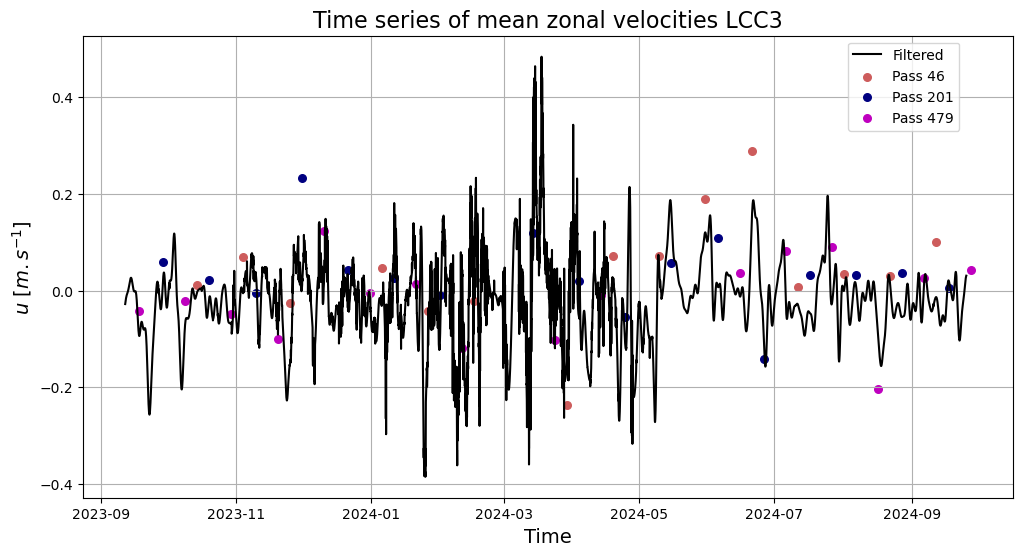

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(u_da2.TIME, u_layer_mean ,'k', label='Filtered')
plt.scatter(sp46.time46, sp46.mean_u46,s=30,color='indianred', label='Pass 46')
plt.scatter(sp201.time201, sp201.mean_u201,s=30,color='navy', label='Pass 201')
plt.scatter(sp479.time479, sp479.mean_u479,s=30,color='m', label='Pass 479')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$u~[m.s^{-1}]$', fontsize=14)
plt.title('Time series of mean zonal velocities LCC3', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=(0.95, 1))
# plt.savefig('LCC3vsSWOT.png', dpi=300);

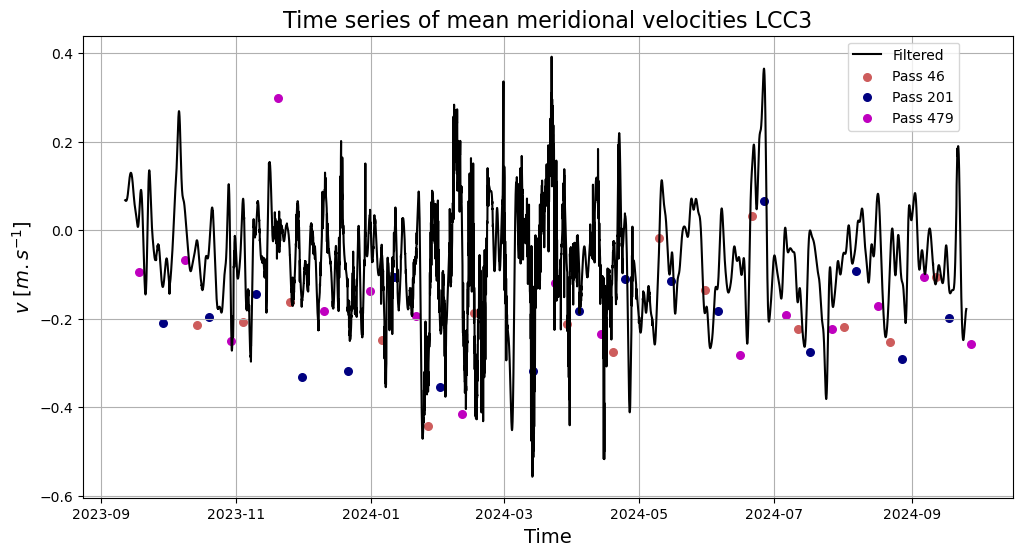

In [38]:

plt.figure(figsize=(12, 6))
plt.plot(v_da2.TIME, v_layer_mean ,'k', label='Filtered')
plt.scatter(sp46.time46, sp46.mean_v46,s=30,color='indianred', label='Pass 46')
plt.scatter(sp201.time201, sp201.mean_v201,s=30,color='navy', label='Pass 201')
plt.scatter(sp479.time479, sp479.mean_v479,s=30,color='m', label='Pass 479')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$v~[m.s^{-1}]$', fontsize=14)
plt.title('Time series of mean meridional velocities LCC3', fontsize=16)
plt.grid(True)
plt.legend(bbox_to_anchor=(0.95, 1))
# plt.savefig('LCC3vsSWOT_v.png', dpi=300);

### Comparisons

In [40]:
def find_nearest_index(time, target_time):
    return np.argmin(np.abs(time - target_time))


mooring_time = np.array(u_da2['TIME'], dtype='datetime64[ns]')


satellite_times = np.concatenate([
    sp46.time46.values.astype('datetime64[ns]'),
    sp201.time201.values.astype('datetime64[ns]'),
    sp479.time479.values.astype('datetime64[ns]')
], axis=0)

time_indices = [find_nearest_index(mooring_time, sat_time) for sat_time in np.sort(satellite_times)]
# u_da2.TIME[time_indices]

In [41]:
print("satellite times:", np.sort(satellite_times))
print("sp46 times:", sp46.time46.values.astype('datetime64[ns]'))
print("sp201 times:", sp201.time201.values.astype('datetime64[ns]'))
print("sp479 times:", sp479.time479.values.astype('datetime64[ns]'))

satellite times: ['2023-09-18T01:36:15.501928192' '2023-09-28T23:59:14.404390912'
 '2023-10-08T22:21:17.110637312' '2023-10-14T07:18:36.012119680'
 '2023-10-19T20:44:18.282083840' '2023-10-29T19:06:22.474696192'
 '2023-11-04T04:03:41.410632576' '2023-11-09T17:29:23.537391744'
 '2023-11-19T15:51:27.609002880' '2023-11-25T00:48:46.680643200'
 '2023-11-30T14:14:29.062293504' '2023-12-10T12:36:32.450079616'
 '2023-12-21T10:59:32.973996544' '2023-12-31T09:21:38.619861632'
 '2024-01-05T18:18:56.802205568' '2024-01-11T07:44:38.336036096'
 '2024-01-21T06:06:43.935063168' '2024-01-26T15:04:02.690994944'
 '2024-02-01T04:29:44.667519232' '2024-02-11T02:51:48.456747008'
 '2024-02-16T11:49:07.518909952' '2024-02-22T01:14:49.823690496'
 '2024-03-02T23:36:53.660560128' '2024-03-08T08:34:11.264840192'
 '2024-03-13T21:59:52.183920384' '2024-03-23T20:21:56.985154944'
 '2024-03-29T05:19:15.025489024' '2024-04-03T18:44:56.569959936'
 '2024-04-13T17:07:02.276277632' '2024-04-19T02:04:20.957504896'
 '2024-0

In [42]:
swot_u_all = np.concatenate([sp46.mean_u46, sp201.mean_u201, sp479.mean_u479], axis=0)
swot_v_all = np.concatenate([sp46.mean_v46, sp201.mean_v201, sp479.mean_v479], axis=0)

swot_u_all.shape

(52,)

In [43]:
ice_start = np.datetime64("2024-01-31")
ice_end   = np.datetime64("2024-04-07")
# full_depth = np.datetime64("2023-11-10")

time_val = u_da2.TIME[time_indices]

u_vals = u_layer_mean[time_indices]
v_vals = v_layer_mean[time_indices]

sorted_idx = np.argsort(time_val)
sorted_time = time_val[sorted_idx]
sorted_u = u_vals[sorted_idx]
sorted_v = v_vals[sorted_idx]

mask = (sorted_time < ice_start) | (sorted_time > ice_end)
# mask = (sorted_time < full_depth) 

sorted_indices = np.argsort(satellite_times)
swot_u_all = swot_u_all[sorted_indices]
swot_v_all = swot_v_all[sorted_indices]

time_mooring = sorted_time[mask]
time_satellite = np.sort(satellite_times)[mask]
sorted_u = sorted_u[mask]
swot_u_filtered = swot_u_all[mask]
sorted_v = sorted_v[mask]
swot_v_filtered = swot_v_all[mask]

mask_nan = ~np.isnan(sorted_u) & ~np.isnan(swot_u_filtered)
    
    
# Filtered data
u_mooring = sorted_u[mask_nan]
u_swot = swot_u_filtered[mask_nan]
v_mooring = sorted_v[mask_nan]
v_swot = swot_v_filtered[mask_nan]

corr_u = np.abs(np.corrcoef(u_swot, u_mooring))[0, 1]
rmse_u = np.sqrt(np.nanmean(u_swot - u_mooring)**2) 
corr_v = np.abs(np.corrcoef(v_swot, v_mooring))[0, 1]
rmse_v = np.sqrt(np.nanmean(v_swot - v_mooring)**2) 

In [44]:
# r_u = []
# r_v = []
# RMSE_u = []
# RMSE_v = []
# layer_results = {}

# for i in range(int(np.min(depths)), int(np.max(depths)), 15):
#     ek_layer = (depths >= i) & (depths < i+15)
#     u_layer = u_da2[:, ek_layer]   
#     v_layer = v_da2[:, ek_layer]
#     u_layer_mean = np.nanmean(u_layer, axis=1)
#     v_layer_mean = np.nanmean(v_layer, axis=1)
    
#     u_vals = u_layer_mean[time_indices]
#     v_vals = v_layer_mean[time_indices]
    
#     sorted_idx = np.argsort(time_val)
#     sorted_time = time_val[sorted_idx]
#     sorted_u = u_vals[sorted_idx]
#     sorted_v = v_vals[sorted_idx]
    
#     # mask = (sorted_time < ice_start) | (sorted_time > ice_end)
#     # mask = (sorted_time < full_depth) 
    
#     sorted_indices = np.argsort(satellite_times)
#     swot_u_all = swot_u_all[sorted_indices]
#     swot_v_all = swot_v_all[sorted_indices]
    
#     # time_mooring = sorted_time[mask]
#     # time_satellite = np.sort(satellite_times)[mask]
#     # sorted_u = sorted_u[mask]
#     # swot_u_filtered = swot_u_all[mask]
#     # sorted_v = sorted_v[mask]
#     # swot_v_filtered = swot_v_all[mask]
    
#     mask_nan = ~np.isnan(sorted_u) & ~np.isnan(swot_u_all)
    
    
#     # Filtered data
#     u_mooring = sorted_u[mask_nan]
#     u_swot = swot_u_all[mask_nan]
#     v_mooring = sorted_v[mask_nan]
#     v_swot = swot_v_all[mask_nan]

#     corr_u = np.abs(np.corrcoef(u_swot, u_mooring))[0, 1]
#     rmse_u = np.sqrt(np.nanmean(u_swot - u_mooring)**2) 
#     corr_v = np.abs(np.corrcoef(v_swot, v_mooring))[0, 1]
#     rmse_v = np.sqrt(np.nanmean(v_swot - v_mooring)**2) 

#     r_u.append(corr_u)
#     r_v.append(corr_v)
#     RMSE_u.append(corr_u)
#     RMSE_v.append(corr_u)

#     # Store results in dictionary for this layer
#     layer_results[f"{i}_{i+10}"] = {
#         "corr_u": corr_u,
#         "corr_v": corr_v,
#         "rmse_u": rmse_u,
#         "rmse_v": rmse_v,
#         "depth_range": f"{i} to {i+10}m"
#     }
    
#     print(f"Layer {i} to {i+15}m:")
#     print(f"r_u: {corr_u:.3f}, r_v: {corr_v:.3f}")
#     print(f"RMSE_u: {rmse_u:.3f}, RMSE_v: {rmse_v:.3f}")
#     print("---")

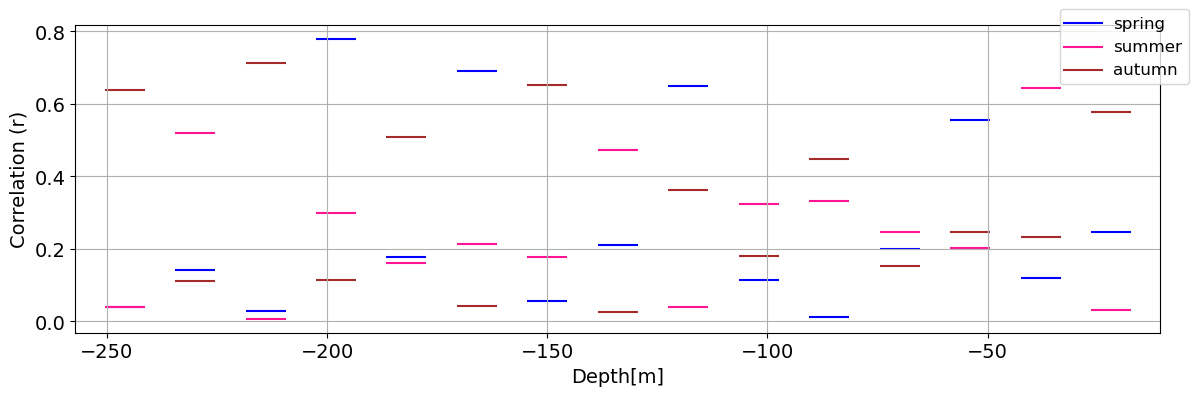

In [45]:
months = ["Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

seasons = ["spring", "summer", "autumn"]
season_bounds = {
    "spring": (3, 5),   # Apr–Jun
    "summer": (6, 8),   # Jul–Sep
    "autumn": (9, 11)   # Oct–Dec
}

layer_bounds = np.linspace( int(np.min(depths)), int(np.max(depths)), 15)

corr_spring_u = [0.126, 0.425, 0.435, 0.185, 0.002, 0.748, 0.180, 0.095,  0.024, 0.136, 0.295, 0.474, 0.007, 0.005, 0.610]
corr_spring_v = [0.039, 0.141, 0.027, 0.780, 0.178, 0.691, 0.057, 0.211, 0.649, 0.115, 0.011, 0.199, 0.556 ,  0.120, 0.247]

corr_summer_u = [0.139, 0.186, 0.501, 0.206, 0.112, 0.38,  0.131, 0.1, 0.235,  0.103, 0.069, 0.061, 0.150, 0.177, 0.190]
corr_summer_v = [0.038, 0.519, 0.007, 0.3, 0.161, 0.212, 0.177 , 0.474, 0.039 , 0.324, 0.331, 0.246, 0.202, 0.643, 0.031]

corr_aut_u = [0.447, 0.215, 0.803, 0.052, 0.300, 0.208, 0.806, 0.114, 0.433, 0.455, 0.702, 0.585, 0.259, 0.412, 0.428]
corr_aut_v = [0.638 , 0.112, 0.712, 0.113, 0.509, 0.043, 0.652, 0.025, 0.363, 0.181, 0.448, 0.152, 0.246, 0.233, 0.578]

plt.figure(figsize=(14, 4))
# plt.scatter(layer_bounds, corr_spring_u, marker='s', s=10, color='deeppink', label='spring')
plt.scatter(layer_bounds, corr_spring_v, marker='_', s=800, color='blue', label='spring')

# plt.scatter(layer_bounds, corr_summer_u, marker='s', s=10, color='orange', label='summer')
plt.scatter(layer_bounds, corr_summer_v, marker='_', s=800, color='deeppink', label='summer')

# plt.scatter(layer_bounds, corr_aut_u, marker='s', s=10, color='brown', label='autumn')
plt.scatter(layer_bounds, corr_aut_v, marker='_',s=800, color='brown', label='autumn')
plt.grid()
plt.legend(bbox_to_anchor=(0.9, 0.78), fontsize=12)
plt.xlabel('Depth[m]', fontsize=14)
plt.tick_params(axis='x', labelsize=14, colors='k')
plt.tick_params(axis='y', labelsize=14, colors='k')
plt.ylabel('Correlation (r)', fontsize=14)
fig.tight_layout()
plt.show()

# plt.savefig('Figures/RMSD vs corr SWOT_ SWOT1.png', dpi=300);

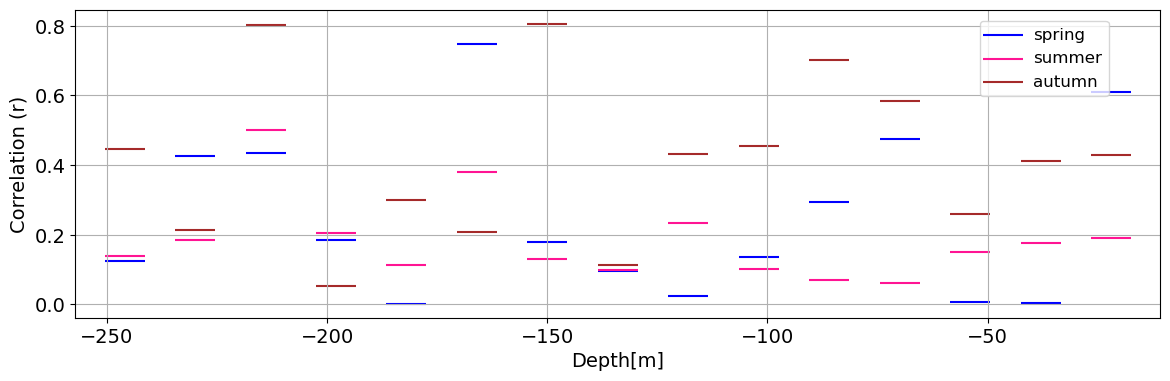

In [46]:
plt.figure(figsize=(14, 4))

plt.scatter(layer_bounds, corr_spring_u, marker='_', s=800, color='blue', label='spring')

plt.scatter(layer_bounds, corr_summer_u, marker='_', s=800, color='deeppink', label='summer')

plt.scatter(layer_bounds, corr_aut_u, marker='_', s=800, color='brown', label='autumn')

plt.xlabel('Depth[m]', fontsize=14)
plt.tick_params(axis='x', labelsize=14, colors='k')
plt.tick_params(axis='y', labelsize=14, colors='k')
plt.ylabel('Correlation (r)', fontsize=14)
plt.legend(bbox_to_anchor=(0.96, 0.99), fontsize=12)
plt.grid()
fig.tight_layout()
plt.show()

In [47]:
# # mask = ~np.isnan(swot_u_all)
# # swot_u_all = swot_u_all[mask]
# # swot_v_all = swot_v_all[mask]

# u_auto_r = sm.tsa.acf(u_swot_fk)
# v_auto_r = sm.tsa.acf(v_swot_fk)

# lags = np.arange(len(u_auto_r))

# alpha = 0.05
# nlags = 40
# N = len(u_swot_fk)

# # --- Compute ACF with CI ---
# u_auto_r, confint_v = sm.tsa.acf(u_swot_fk, alpha=alpha, fft=True, nlags=nlags)
# lags = np.arange(len(u_auto_r))

# # --- Compute approximate p-values ---
# se = 1.0 / np.sqrt(N)
# p_values_v = 2 * (1 - norm.cdf(np.abs(u_auto_r) / se))

# # --- Plot ---
# fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# # Top: ACF with confidence intervals
# axes[0].stem(lags, u_auto_r, basefmt=" ", linefmt="C0-", markerfmt="C0o")
# axes[0].fill_between(lags, confint_v[:,0]-u_auto_r, confint_v[:,1]-u_auto_r,
#                      color="lightblue", alpha=0.5)
# axes[0].axhline(0, color="black", linewidth=1)
# axes[0].set_title("ACF of v with 95% confidence intervals")
# axes[0].set_ylabel("Autocorrelation")

# # Bottom: p-values
# axes[1].plot(lags, p_values_v, marker="o", linestyle="-", color="C1")
# axes[1].axhline(0.05, color="red", linestyle="--", label="p = 0.05")
# axes[1].set_title("p-values for autocorrelations of u")
# axes[1].set_xlabel("Lag")
# axes[1].set_ylabel("p-value")
# # axes[1].set_yscale("log")
# axes[1].legend()

# plt.tight_layout()
# plt.show()

In [48]:
# def effective_sample_size(series, alpha=0.05, nlags=40):
#     """
#     Compute effective sample size based on ACF decay.
#     """
#     N = len(series)

#     # ACF with confidence intervals
#     acf_vals, confint = sm.tsa.acf(series, alpha=alpha, fft=True, nlags=nlags)

#     # Approximate cutoff: first lag where autocorr not significant anymore
#     ci_width = confint[:,1] - acf_vals   # distance from acf to upper CI
#     crit = ci_width[1]  # ~2/sqrt(N)
#     try:
#         K = np.where(np.abs(acf_vals) < crit)[0][0]
#     except IndexError:
#         K = nlags  # if never crosses, use nlags as cutoff

#     # Integral time scale tau
#     tau = 1 + 2 * np.sum(acf_vals[1:K])
#     n_eff = int(N / tau)

#     return acf_vals, confint, n_eff, tau, K

# # --- Apply to your data ---
# u_acf, u_confint, n_eff_u, tau_u, K_u = effective_sample_size(u_swot_fk)
# v_acf, v_confint, n_eff_v, tau_v, K_v = effective_sample_size(sorted_u)

# print(f"U-series: N = {len(u_swot_fk)}, tau ≈ {tau_u:.2f}, n_eff ≈ {n_eff_u}")
# print(f"V-series: N = {len(sorted_u)}, tau ≈ {tau_v:.2f}, n_eff ≈ {n_eff_v}")

# # --- Example of using n_eff in your SE formula ---
# SE_u = std_u / np.sqrt(n_eff_u)
# SE_v = std_v / np.sqrt(n_eff_v)
# print(f"SE_u = {SE_u:.4f}, SE_v = {SE_v:.4f}")

### Getting the computed velocities

In [50]:
swot46_data = pd.read_csv('/Users/dihyachaal/Desktop/data_SWOT_ugosLCC4/swot_ugos_46_LCC4.csv')
swot201_data = pd.read_csv('/Users/dihyachaal/Desktop/data_SWOT_ugosLCC4/swot_ugos_201_LCC4.csv')
swot479_data = pd.read_csv('/Users/dihyachaal/Desktop/data_SWOT_ugosLCC4/swot_ugos_479_LCC4.csv')
# swot201_data = swot201_data.drop(index=[3])
# swot479_data = swot479_data.drop(index=[3, 4])

swot46_data['time'] = pd.to_datetime(swot46_data['time'])
swot201_data['time'] = pd.to_datetime(swot201_data['time'])
swot479_data['time'] = pd.to_datetime(swot479_data['time'])

# swot46_data['month'] = swot46_data['time'].dt.month
# swot201_data['month'] = swot201_data['time'].dt.month
# swot479_data['month'] = swot479_data['time'].dt.month

# monthly_idx_fk = swot46_data.groupby('month').groups
# monthly_idx_fk201 = swot201_data.groupby('month').groups
# monthly_idx_fk479 = swot479_data.groupby('month').groups

# # winter_idx = np.concatenate([monthly_idx_swot[1], monthly_idx_swot[2], monthly_idx_swot[3]])
# # sp46 = sp46.isel(TIME=winter_idx)
# # p201 = sp201.isel(TIME=winter_idx)

# spring_idx = np.concatenate([monthly_idx_fk[4], monthly_idx_fk[5], monthly_idx_fk[6]])
# spring_idx201 = np.concatenate([monthly_idx_fk201[4], monthly_idx_fk201[5], monthly_idx_fk201[6]])
# spring_idx479 = np.concatenate([monthly_idx_fk479[4], monthly_idx_fk479[5], monthly_idx_fk479[6]])

# swot46_data = swot46_data.iloc[spring_idx]
# swot201_data = swot201_data.iloc[spring_idx201]
# swot479_data = swot479_data.iloc[spring_idx479]

In [51]:
time46_bis = pd.to_datetime(swot46_data['time']).values
time201_bis = pd.to_datetime(swot201_data['time']).values
time479_bis = pd.to_datetime(swot479_data['time']).values

ind46 = np.where((time46_bis >= start) & (time46_bis <= end))
ind201 = np.where((time201_bis >= start) & (time201_bis <= end))
ind479 = np.where((time479_bis >= start) & (time479_bis <= end))
time46_bis = time46_bis[ind46]
time201_bis = time201_bis[ind201]
time479_bis = time479_bis[ind479]

satellite_times_bis = np.concatenate([
    time46_bis.astype('datetime64[ns]'),
    time201_bis.astype('datetime64[ns]'),
    time479_bis.astype('datetime64[ns]')
], axis=0)


time_indices_bis = [find_nearest_index(mooring_time, sat_time) for sat_time in np.sort(satellite_times_bis)]


swot_u_fk = np.concatenate([swot46_data.ugeos, swot201_data.ugeos, swot479_data.ugeos], axis=0)
swot_v_fk = np.concatenate([swot46_data.vgeos, swot201_data.vgeos, swot479_data.vgeos], axis=0)
mask_fk = (np.sort(satellite_times_bis) < ice_start) | (np.sort(satellite_times_bis) > ice_end)
# mask_fk = (np.sort(satellite_times_bis) < full_depth) 

# Sort by time
sorted_indices_bis = np.argsort(satellite_times_bis)
swot_u_fk = swot_u_fk[sorted_indices_bis]
swot_u_fk = swot_u_fk[mask_fk]
swot_v_fk = swot_v_fk[sorted_indices_bis]
swot_v_fk = swot_v_fk[mask_fk]

# Get mooring values at that moment
time_val_bis = u_da2.TIME[time_indices_bis].values
# time_val_bis = filtered_u2.TIME[time_indices_bis].values
u_vals_bis = u_layer_mean[time_indices_bis]

sorted_idx_bis = np.argsort(time_val_bis)
sorted_time_bis = time_val_bis[sorted_idx_bis]
sorted_u_fk = u_vals_bis[sorted_idx_bis]
sorted_u_fk = sorted_u_fk[mask_fk]

v_vals_bis = v_layer_mean[time_indices_bis]

sorted_idx_bis = np.argsort(time_val_bis)
sorted_time_bis = time_val_bis[sorted_idx_bis]
sorted_v_fk = v_vals_bis[sorted_idx_bis]
sorted_v_fk = sorted_v_fk[mask_fk]

time_mooring = sorted_time_bis[mask_fk]

### Getting rid of NaN values

In [53]:
mask_bis = ~np.isnan(sorted_u_fk) & ~np.isnan(swot_u_fk)

u_mooring_fk = sorted_u_fk[mask_bis]
u_swot_fk = swot_u_fk[mask_bis]
v_mooring_fk = sorted_v_fk[mask_bis]
v_swot_fk = swot_v_fk[mask_bis]

In [54]:
mean_u = np.nanmean(swot_u_all)
mean_u_fk = np.nanmean(u_swot_fk)
mean_u_m = np.nanmean(sorted_u)

std_u = np.nanstd(swot_u_all)
std_u_fk = np.nanstd(u_swot_fk)
std_u_m = np.nanstd(sorted_u)

mean_v = np.nanmean(swot_v_all)
mean_v_m = np.nanmean(sorted_v)
mean_v_fk = np.nanmean(v_swot_fk)

std_v = np.nanstd(swot_v_all)
std_v_m = np.nanstd(sorted_v)
std_v_fk = np.nanstd(v_swot_fk)

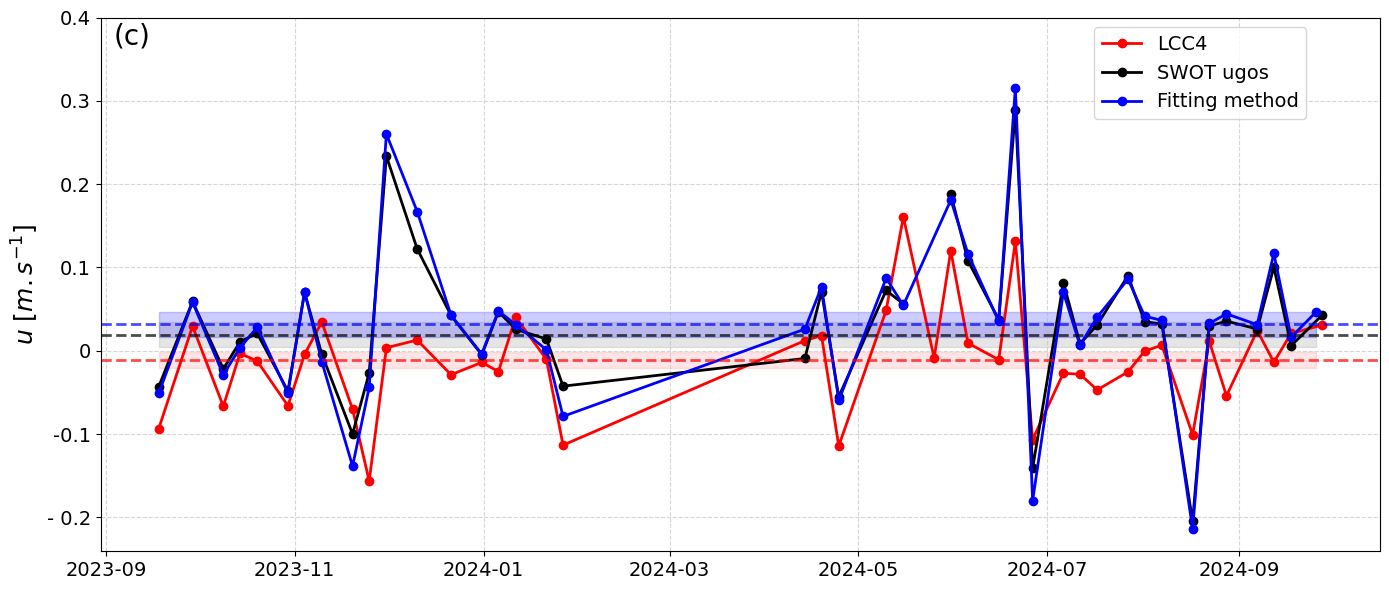

In [55]:
plt.figure(figsize=(14, 6))
plt.plot(time_satellite, sorted_u, 'o-',c='red', linewidth=2, label='LCC4') #time_mooring
plt.plot(time_satellite, swot_u_filtered, 'o-', c='k', linewidth= 2, label='SWOT ugos')
plt.plot(time_mooring[mask_bis], u_swot_fk,'o-', color='b',linewidth=2,label='Fitting method')

plt.fill_between(time_mooring , mean_u - (std_u/np.sqrt(40)), mean_u + (std_u/np.sqrt(40)), color='gray', alpha=0.2)
plt.fill_between(time_mooring, mean_u_m - (std_u_m/np.sqrt(42)), mean_u_m + (std_u_m/np.sqrt(42)), color='r', alpha=0.1)
plt.axhline(mean_u, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_u_m, color='r', linestyle='--', linewidth=2,alpha=0.7)

plt.fill_between(time_mooring , mean_u_fk - (std_u_fk/np.sqrt(41)), mean_u_fk + (std_u_fk/np.sqrt(41)), color='blue', alpha=0.2)
plt.axhline(mean_u_fk, color='b', linestyle='--', linewidth=2, alpha=0.7)

# plt.plot(np.sort(satellite_times), swot_u_fk, 'o-', c='blue', label='SWOT ugos')
# plt.plot(np.sort(satellite_times), df_interp_swot_u, 'o-', c='blue', label='SWOT ugos')
# plt.plot(sp46.time46, sp46.mean_u46, 'o-' ,c='indianred', label='Pass 46')
# plt.plot(sp201.time201, sp201.mean_u201,'o-',c='navy', label='Pass 201')
# plt.plot(sp479.time479, sp479.mean_u479, 'o-' ,c='m', label='Pass 479')

plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4], ['- 0.2', '-0.1','0', '0.1', '0.2','0.3','0.4'], fontsize=14)
plt.text(0.01, 0.95, "(c)", fontsize=20, transform=plt.gca().transAxes)
# plt.xlabel('Time', fontsize=14)
plt.tick_params(axis='x', labelsize=14, colors='k')
plt.ylabel(r'$u~[m.s^{-1}]$', fontsize=18)
# plt.title('Time series of mean zonal velocities LCC3', fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1), fontsize=14)
plt.tight_layout()
# plt.savefig('Figures/LCC4vsSWOT_u_ice.png', dpi=300);

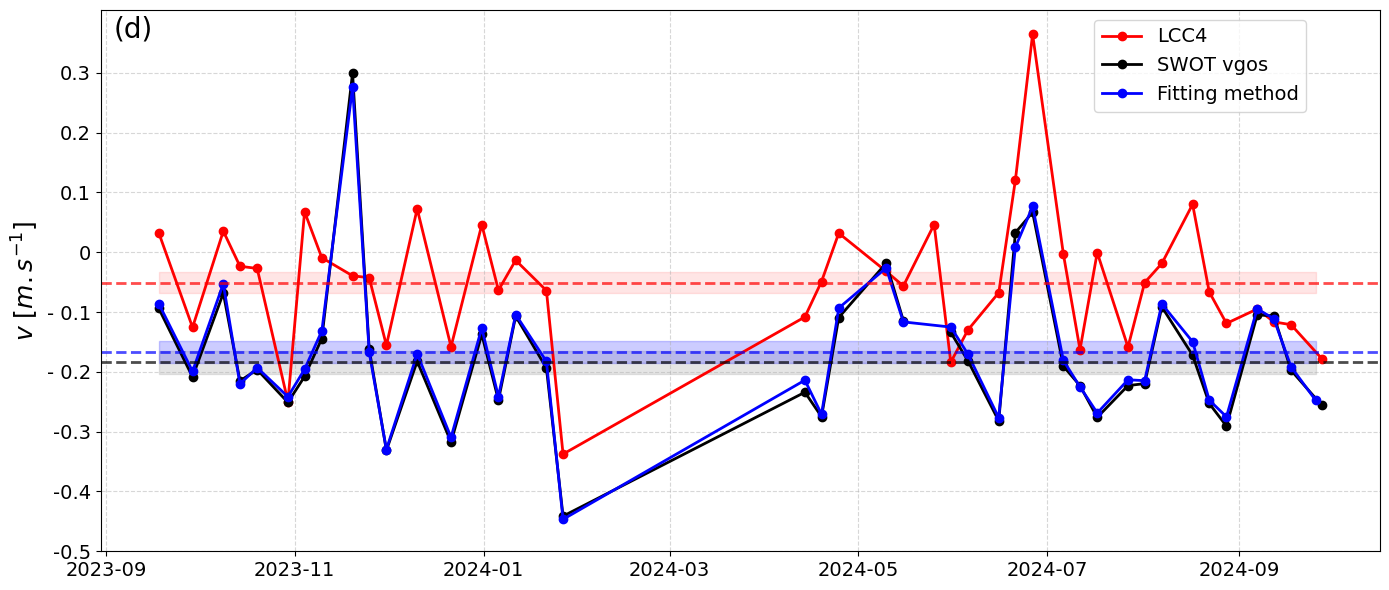

In [56]:
plt.figure(figsize=(14, 6))
plt.plot(time_satellite, sorted_v, 'o-',c='red', linewidth=2, label='LCC4')
plt.plot(time_satellite, swot_v_filtered, 'ko-', linewidth=2,label='SWOT vgos')
plt.plot(time_mooring[mask_bis], v_swot_fk,'o-', color='b',linewidth=2,label='Fitting method')
plt.text(0.01, 0.95, "(d)", fontsize=20, transform=plt.gca().transAxes)
# plt.plot(sp46.time46, sp46.mean_v46, 'o-' ,c='indianred', label='Pass 46')
# plt.plot(sp201.time201, sp201.mean_v201,'o-',c='navy', label='Pass 201')
# plt.plot(sp479.time479, sp479.mean_v479, 'o-' ,c='m', label='Pass 479')

plt.fill_between(time_mooring , mean_v - (std_v/np.sqrt(40)), mean_v + (std_v/np.sqrt(40)), color='gray', alpha=0.2)
plt.fill_between(time_mooring, mean_v_m - (std_v_m/np.sqrt(42)), mean_v_m + (std_v_m/np.sqrt(42)), color='r', alpha=0.1)
plt.axhline(mean_v, color='k', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(mean_v_m, color='r', linestyle='--', linewidth=2,alpha=0.7)

plt.fill_between(time_mooring , mean_v_fk - (std_v_fk/np.sqrt(41)), mean_v_fk + (std_v_fk/np.sqrt(41)), color='blue', alpha=0.2)
plt.axhline(mean_v_fk, color='b', linestyle='--', linewidth=2, alpha=0.7)

plt.yticks([-0.5,-0.4,-0.3,-0.2, -0.1, 0, 0.1,0.2,0.3], ['-0.5','-0.4','-0.3','- 0.2','- 0.1','0', '0.1', '0.2', '0.3'], fontsize=14)

plt.tick_params(axis='x', labelsize=14, colors='k')
plt.ylabel(r'$v~[m.s^{-1}]$', fontsize=18)
# plt.title('Time series of mean zonal velocities LCC3', fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(0.95, 1), fontsize=14)
plt.tight_layout()
# plt.savefig('Figures/LCC4vsSWOT_v_ice.png', dpi=300);

Text(0.01, 0.93, '(a)')

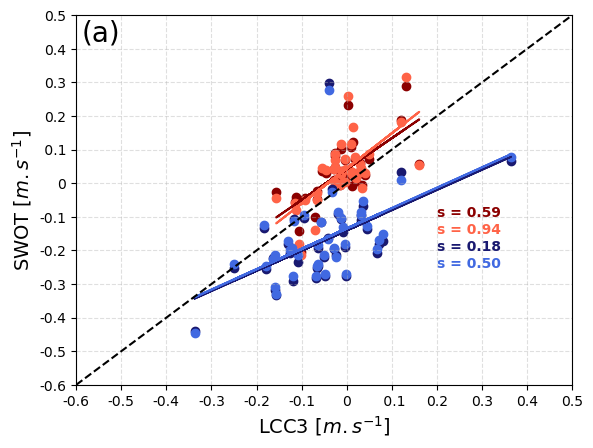

In [64]:
plt.scatter(u_mooring, u_swot, c='darkred', label='SWOT u geos')
plt.scatter(u_mooring_fk, u_swot_fk, c='tomato', label='u_fk')
plt.scatter(v_mooring, v_swot, marker='o', c='midnightblue', label='SWOT v geos')
plt.scatter(v_mooring_fk, v_swot_fk, marker='o', c='royalblue', label='v_fk')
plt.grid(linestyle='--',alpha=0.4)

a, b = np.polyfit(u_mooring, u_swot, 1)
c, d = np.polyfit(u_mooring_fk, u_swot_fk, 1)
e, f = np.polyfit(v_mooring, v_swot, 1)
i, j = np.polyfit(v_mooring_fk, v_swot_fk, 1)

# #adding linear regression line to scatterplot 
plt.plot(u_mooring, a* u_mooring+b, c='darkred')
plt.plot(u_mooring_fk, c*u_mooring_fk+d, c='tomato')
plt.plot(v_mooring, e* v_mooring+f, c='midnightblue')
plt.plot(v_mooring_fk, i*v_mooring_fk+j, c='royalblue')

plt.xticks([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], ['-0.6','-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3','0.4','0.5'])
plt.yticks([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5], ['-0.6','-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0', ' 0.1', '0.2', '0.3', '0.4','0.5'])

plt.xlim(-0.6, 0.5)
plt.ylim(-0.6, 0.5)

plt.text(0.2, -0.15, "s = 0.94" , color='tomato', weight='bold')
plt.text(0.2, -0.1, "s = 0.59" , color='darkred', weight='bold')
plt.text(0.2, -0.2, "s = 0.18" , color='midnightblue', weight='bold')
plt.text(0.2, -0.25, "s = 0.50" , color='royalblue', weight='bold')

plt.plot([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3,0.4, 0.5], c='k', linestyle='--')
# plt.plot([-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3], [-0.3,-0.2, -0.1, 0, 0.1, 0.2, 0.3], c='k', linestyle='--')


plt.xlabel('LCC3 $[m.s^{-1}]$', fontsize=14)
plt.ylabel(r'SWOT $[m.s^{-1}]$', fontsize=14)
# plt.title('Geostrophic velocities from 09-2023 to 09-2024', fontsize=14)
# plt.legend(loc = (0.1, 0.71), fontsize=12)
plt.text(0.01, 0.93, "(a)", fontsize=20, transform=plt.gca().transAxes)


# plt.savefig('scatter_plot_LCC3.png', dpi=300);

In [66]:
i

0.6063240700042418

### Computing the full speed

In [69]:
speed_swot_fk = np.sqrt(u_swot_fk**2 + v_swot_fk**2)
speed_mooring = np.sqrt(u_mooring**2 + v_mooring**2)
speed_swot =  np.sqrt(u_swot**2 +  v_swot**2)
speed_mooring_fk =  np.sqrt(u_mooring_fk**2 +  v_mooring_fk**2)

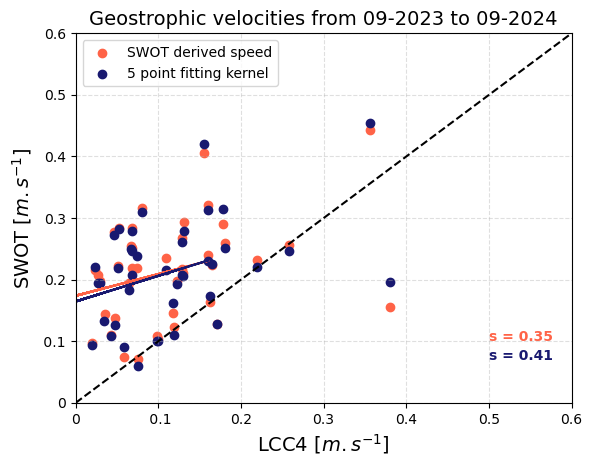

In [71]:
plt.scatter(speed_mooring, speed_swot, c='tomato', label='SWOT derived speed')

plt.scatter(speed_mooring_fk, speed_swot_fk, marker='o', c='midnightblue', label='5 point fitting kernel')

k,l = np.polyfit(speed_mooring, speed_swot, 1)
m, n = np.polyfit(speed_mooring_fk, speed_swot_fk, 1)

plt.yticks([0, 0.1, 0.2, 0.3, 0.4,0.5,0.6], ['0', ' 0.1', '0.2', '0.3', '0.4','0.5','0.6'])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4,0.5,0.6], ['0', ' 0.1', '0.2', '0.3', '0.4','0.5','0.6'])

plt.plot([0, 0.1, 0.2, 0.3, 0.4,0.5,0.6], [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6], c='k', linestyle='--')

plt.plot(u_mooring, k *u_mooring+l, c='tomato');
plt.plot(u_mooring, m *u_mooring+n, c='midnightblue');

plt.grid(linestyle='--',alpha=0.4)
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)
plt.text(0.5, 0.1, "s = 0.35" , color='tomato', weight='bold')
plt.text(0.5, 0.07, "s = 0.41" , color='midnightblue', weight='bold')
plt.xlabel('LCC4 $[m.s^{-1}]$', fontsize=14)
plt.ylabel(r'SWOT $[m.s^{-1}]$', fontsize=14)
plt.title('Geostrophic velocities from 09-2023 to 09-2024', fontsize=14)
plt.legend(loc = 'upper left')
# plt.savefig('scatter_plot_SWOT4_other.png', dpi=300);

In [73]:
# Compute correlation
corr = np.abs(np.corrcoef(v_swot, v_mooring))[0, 1]
corr

0.5608615209969032

In [75]:
rmse = np.sqrt(np.nanmean(u_swot - u_mooring)**2) 
rmse

0.04298419076924508

In [77]:
np.shape(v_swot)

(41,)

In [79]:
# plt.plot(time_satellite[mask_bis], v_swot_fk,'ko-')
# plt.plot(time_mooring[mask_bis], v_mooring_fk,'ro-');

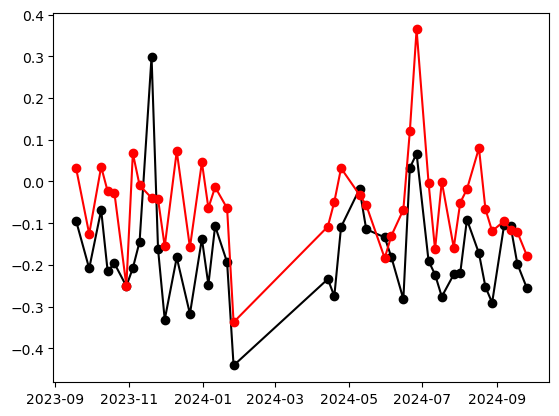

In [81]:
plt.plot(time_mooring[mask_nan], v_swot,'ko-')
plt.plot(time_mooring[mask_nan], v_mooring,'ro-');

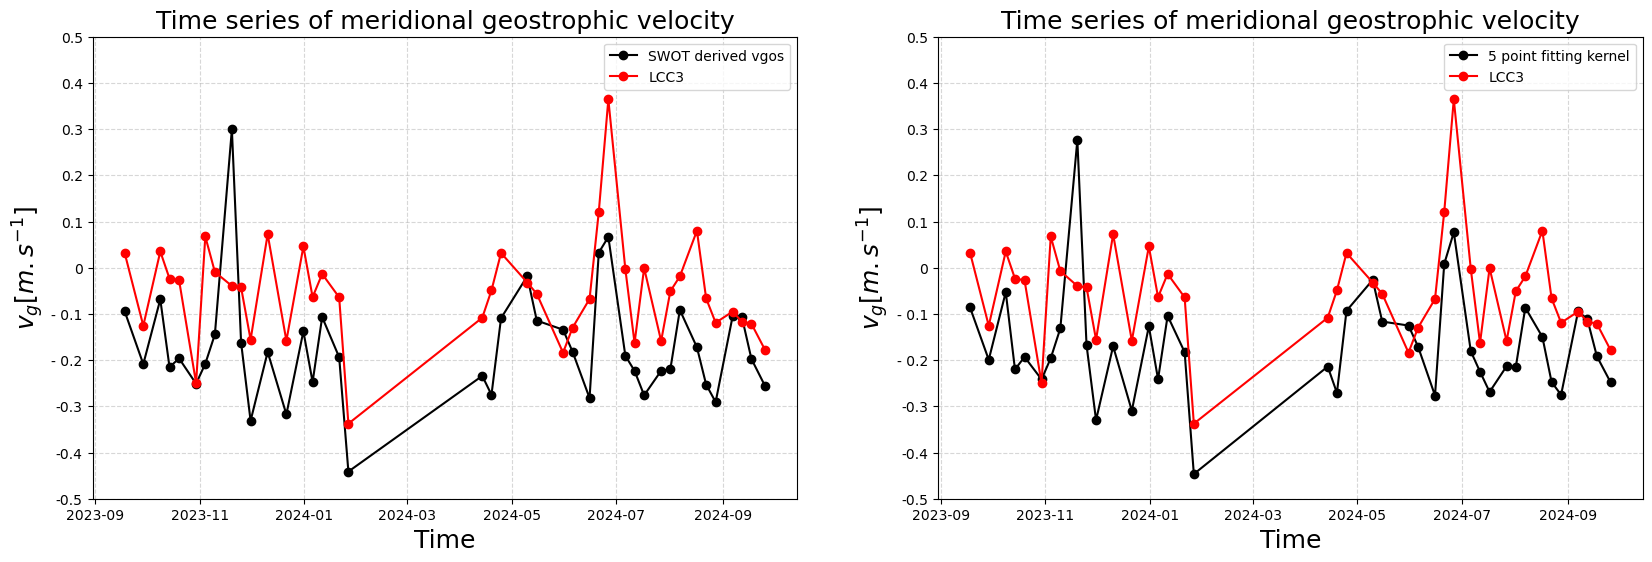

In [83]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
axs[1].plot(time_mooring[mask_bis], v_swot_fk,'ko-', label='5 point fitting kernel')
axs[1].plot(time_mooring[mask_bis], v_mooring_fk,'ro-', label='LCC3')

axs[1].set_xlabel('Time', fontsize=18)
axs[1].set_ylabel(r'$v_g[m.s^{-1}]$', fontsize=18)
axs[1].set_title('Time series of meridional geostrophic velocity', fontsize=18)
axs[1].set_yticks([-0.5,-0.4,-0.3,-0.2, -0.1, 0, 0.1,0.2,0.3,0.4,0.5], ['-0.5','-0.4','-0.3','- 0.2','- 0.1','0', '0.1', '0.2', '0.3', '0.4','0.5'])
axs[1].grid(alpha=0.5, linestyle='--')
axs[1].legend()

axs[0].plot(time_mooring[mask_nan], v_swot,'ko-', label='SWOT derived vgos');
axs[0].plot(time_mooring[mask_nan], v_mooring,'ro-', label='LCC3')
axs[0].set_xlabel('Time', fontsize=18)
axs[0].set_ylabel(r'$v_g[m.s^{-1}]$', fontsize=18)
axs[0].set_title('Time series of meridional geostrophic velocity', fontsize=18)
axs[0].set_yticks([-0.5,-0.4,-0.3,-0.2, -0.1, 0, 0.1,0.2,0.3,0.4,0.5], ['-0.5','-0.4','-0.3','- 0.2','- 0.1','0', '0.1', '0.2', '0.3', '0.4','0.5'])
axs[0].grid(alpha=0.5, linestyle='--')
axs[0].legend()

# plt.savefig('v_fkvsvLCC3.png', dpi=300)
plt.show();

In [85]:
corr = np.abs(np.corrcoef(speed_swot, speed_mooring))[0, 1]
corr

0.34650942241090754

In [87]:
rmse = np.sqrt(np.nanmean(speed_swot_fk - speed_mooring_fk)**2) 
rmse

0.09710179612015067

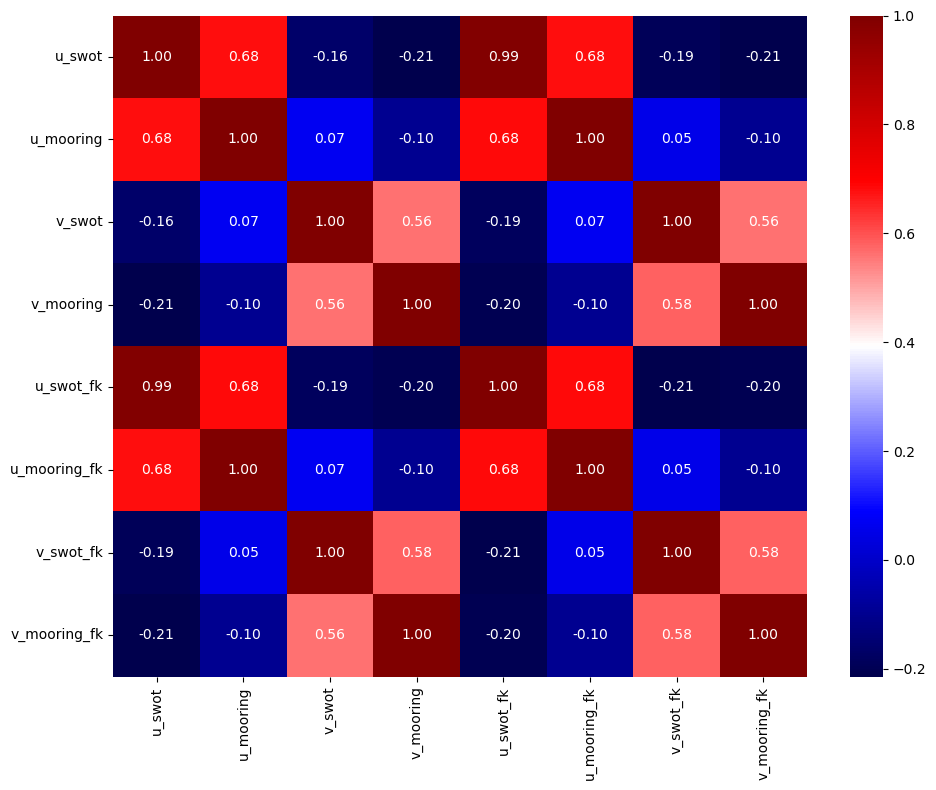

In [89]:
min_len = min(len(u_swot), len(u_mooring), len(v_swot), len(v_mooring),
              len(u_swot_fk), len(u_mooring_fk), len(v_swot_fk), len(v_mooring_fk))

df = pd.DataFrame({
    'u_swot': u_swot[:min_len],
    'u_mooring': u_mooring[:min_len],
    'v_swot': v_swot[:min_len],
    'v_mooring': v_mooring[:min_len],
    'u_swot_fk': u_swot_fk[:min_len],
    'u_mooring_fk': u_mooring_fk[:min_len],
    'v_swot_fk': v_swot_fk[:min_len],
    'v_mooring_fk': v_mooring_fk[:min_len]
})

corr_matrix = df.corr()

df = pd.DataFrame({
    'u_swot': pd.Series(u_swot),
    'u_mooring': pd.Series(u_mooring),
    'v_swot': pd.Series(v_swot),
    'v_mooring': pd.Series(v_mooring),
    'u_swot_fk': pd.Series(u_swot_fk),
    'u_mooring_fk': pd.Series(u_mooring_fk),
    'v_swot_fk': pd.Series(v_swot_fk),
    'v_mooring_fk': pd.Series(v_mooring_fk)
}).dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='seismic', fmt=".2f")
# plt.title("Correlation Matrix: SWOT vs Mooring LCC3 (u, v)")
plt.tight_layout()

# plt.savefig("Cov_Matrix_results_LCC4.png", dpi=300, bbox_inches="tight")
plt.show()

In [91]:
# swot46 = pd.read_csv('swot_ugos_46_derived.csv')
# swot46['time'] = pd.to_datetime(swot46['time'])

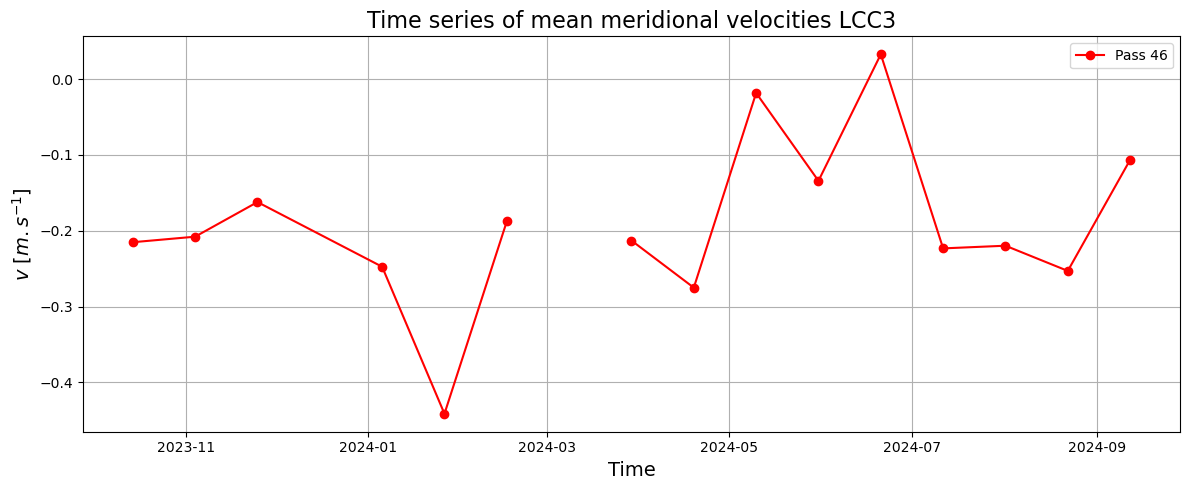

In [93]:
plt.figure(figsize=(12, 5))

# plt.plot(sorted_time, sorted_v, 'ko-', label='LCC3')

# plt.plot(np.sort(satellite_times), swot_v_all, 'o-', c ='blue', label='SWOT vgos')

plt.plot(sp46.time46, sp46.mean_v46, 'o-' ,c='red', label='Pass 46')

# plt.plot(sp201.time201, sp201.mean_v201,'o',c='navy', label='Pass 201')
# plt.plot(time201_bis, v201,'o',c='blue', label='Pass 201')

# plt.plot(sp479.time479, sp479.mean_v479, 'o-' ,c='m', label='Pass 479')

# plt.plot(np.sort(satellite_times)[mask], v_swot, 'o-', c ='blue', label='SWOT vgos')


plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$v~[m.s^{-1}]$', fontsize=14)
plt.title('Time series of mean meridional velocities LCC3', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('LCC3vsSWOT2_v.png', dpi=300);